# EMA cross EMA - Strategy - Backtesting 

### Import Library

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
# from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False)

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [3]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [4]:
data = dataset.copy()

In [5]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [6]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879


In [7]:
def get_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    return signal

In [8]:
def cal_gap(r):
    gap_size = 0
    if r['Low'] > r['High_s1']:
        gap_size = r['Low'] - r['High']
    elif r['High'] < r['Low_s1']:
        gap_size = r['Low_s1'] - r['High']
    return gap_size

In [9]:
def prepare_data(data):
    #
    data["current"] = data.index + pd.DateOffset(minutes=5)
    #
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    # Optimnize
    data['RSI'] = ta.rsi(data["Close"], length=14)
    data['body'] = data.apply(lambda r: abs(r['Close'] - r['Open']), axis=1)
    data['ibs'] = data.apply(lambda x: (0 if (x["High"] == x["Low"]) else round((x["Close"] - x["Low"]) / (x["High"] - x["Low"]), 1)), axis=1)
    data["vol_20_mean"] = data["Volume"].rolling(20).mean()
    data['prev_body'] = data['body'].shift(1)
    data['next_body'] = data['body'].shift(-1)
    adx = ta.adx(data['High'], data['Low'], data['Close'], length = 42)
    data = data.assign(ADX=adx['ADX_42'])
    data['ADX'] = round(data['ADX'])
    data["ATR_14"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data["ATR_5"] = ta.atr(data['High'], data['Low'], data['Close'], length=5)
    data['ATR_5'] = round(data['ATR_5'], 1)
    data['Close_s1'] = data['Close'].shift(1)
    data['price_move'] = data.apply(lambda r: (r['Close'] - r['Close_s1']) - 0.5 * r['ATR_14'] , axis=1)
    data['price_move_round'] = round(data['price_move'])
    data['RSI'] = round(data['RSI'])
    data['upper_wick'] = data.apply(lambda r: r['High'] - max(r['Close'], r['Open']), axis=1)
    data['max_3upper_wick'] = data['upper_wick'].rolling(3).max()
    data['max_3upper_wick'] = round(data['max_3upper_wick'], 1)
    data['lower_shadow'] = data.apply(lambda r: min(r['Close'], r['Open']) - r['Low'], axis=1)
    data['max_3lower_shadow'] = data['lower_shadow'].rolling(3).max()
    data['max_3lower_shadow'] = round(data['max_3lower_shadow'], 1)
    data['min_3lower_shadow'] = data['lower_shadow'].rolling(3).min()
    data['min_3lower_shadow'] = round(data['max_3lower_shadow'], 1)
    # Calculate candle body size
    data["body_size"] = abs(data["Close"] - data["Open"])
    # Calculate standard deviation of last 5 candle bodies
    data["body_std_5"] = data["body_size"].rolling(window=5).std()
    data['body_std_5'] = round(data['body_std_5'], 1)
    data['Low_s1'] = data["Low"].shift(1)
    data['High_s1'] = data["High"].shift(1)
    data['gap'] = data.apply(lambda r: cal_gap(r), axis=1)
    data['max_gap_range_15'] = data['gap'].rolling(15).max()
    data['max_gap_range_15'] = round(data['max_gap_range_15'])
    data['_3xlower_shadow'] = data.apply(lambda r: r['lower_shadow'] * r['lower_shadow'] * r['lower_shadow'] - r['body_size'], axis=1)
    data['max_3xlower_shadow'] = data['_3xlower_shadow'].rolling(3).max()
    data['max_3xlower_shadow'] = round(data['max_3xlower_shadow'], 1)
    # Khong biet tai sao nhung min_3lowershadow lai hieu qua
    data['min_3xlower_shadow'] = data['_3xlower_shadow'].rolling(3).min()
    data['min_3xlower_shadow'] = round(data['min_3xlower_shadow'], 1)
    #
    data['_3xupper_wick'] = data.apply(lambda r: r['upper_wick'] * r['upper_wick'] * r['upper_wick'] - r['body_size'], axis=1)
    data['max_3xupper_wick'] = data['_3xupper_wick'].rolling(3).max()
    data['max_3xupper_wick'] = round(data['max_3xupper_wick'], 1)
    #
    data['min_3xupper_wick'] = data['_3xupper_wick'].rolling(3).min()
    data['min_3xupper_wick'] = round(data['min_3xupper_wick'], 1)
    #
    return data

In [10]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [11]:
prepared_data

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_fast,ema_low,...,Low_s1,High_s1,gap,max_gap_range_15,_3xlower_shadow,max_3xlower_shadow,min_3xlower_shadow,_3xupper_wick,max_3xupper_wick,min_3xupper_wick
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-06 14:15:00,911.0,912.7,910.5,910.6,5948,2020-11-06 14:20:00,912.7,903.5,907.880896,908.796883,...,907.5,911.9,0.0,0.0,-0.399,-0.4,-2.9,4.513,4.5,-2.3
2020-11-06 14:20:00,910.7,911.2,909.4,910.9,4466,2020-11-06 14:25:00,912.7,903.5,908.168430,908.813641,...,910.5,912.7,0.0,0.0,1.997,2.0,-2.9,-0.173,4.5,-2.3
2020-11-06 14:25:00,910.5,911.0,908.5,910.0,3602,2020-11-06 14:30:00,912.7,904.4,908.342865,908.823094,...,909.4,911.2,0.0,0.0,2.875,2.9,-0.4,-0.375,4.5,-0.4
2020-11-06 14:30:00,910.5,910.7,910.5,910.7,78,2020-11-06 14:35:00,912.7,906.2,908.567354,908.838049,...,908.5,911.0,0.0,0.0,-0.200,2.9,-0.2,-0.200,-0.2,-0.4
2020-11-06 14:45:00,908.3,908.3,908.3,908.3,4462,2020-11-06 14:50:00,912.7,906.7,908.541892,908.833762,...,910.5,910.7,2.2,2.0,0.000,2.9,-0.2,0.000,0.0,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-13 14:10:00,1335.0,1335.2,1333.7,1333.8,6120,2025-02-13 14:15:00,1338.5,1333.7,1334.806109,1334.205432,...,1334.4,1335.8,0.0,0.0,-1.199,0.1,-1.2,-1.192,-0.2,-1.2
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583,2025-02-13 14:20:00,1338.5,1333.4,1334.824575,1334.211764,...,1333.7,1335.2,0.0,0.0,-1.499,0.1,-1.5,-1.436,-0.4,-1.4
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753,2025-02-13 14:25:00,1338.5,1333.4,1334.831758,1334.217248,...,1333.4,1335.4,0.0,0.0,-0.492,-0.5,-1.5,0.831,0.8,-1.4


In [12]:
prepared_data[prepared_data.signal != ''].tail(20)

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_fast,ema_low,...,Low_s1,High_s1,gap,max_gap_range_15,_3xlower_shadow,max_3xlower_shadow,min_3xlower_shadow,_3xupper_wick,max_3xupper_wick,min_3xupper_wick
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01 09:50:00,1337.0,1337.5,1336.5,1337.3,1609,2024-11-01 09:55:00,1338.8,1336.4,1339.199980,1339.242278,...,1336.4,1337.5,0.0,3.0,-0.175,-0.2,-0.3,-0.292,-0.2,-0.5
2024-11-06 13:35:00,1331.0,1332.6,1330.1,1331.7,7697,2024-11-06 13:40:00,1332.6,1325.9,1328.278631,1328.212243,...,1329.9,1331.9,0.0,0.0,0.029,1.6,-2.0,0.029,0.2,-2.1
2024-11-08 11:15:00,1329.0,1329.4,1327.8,1328.3,3600,2024-11-08 11:20:00,1333.4,1327.8,1332.619107,1332.634868,...,1328.5,1330.0,0.0,0.0,-0.575,-0.2,-0.7,-0.636,0.8,-0.8
2024-11-21 14:20:00,1281.7,1283.4,1279.0,1283.2,7487,2024-11-21 14:25:00,1283.4,1273.8,1275.936494,1275.871321,...,1277.8,1282.0,0.0,0.0,18.183,18.2,-1.1,-1.492,3.8,-2.9
2024-12-04 09:50:00,1308.4,1308.5,1307.0,1307.3,2631,2024-12-04 09:55:00,1311.2,1306.0,1309.981890,1310.159916,...,1306.5,1308.5,0.0,1.0,-1.073,0.1,-1.8,-1.099,-0.1,-1.8
2024-12-05 11:30:00,1313.0,1313.0,1312.8,1312.8,179,2024-12-05 11:35:00,1313.0,1305.1,1308.759051,1308.758093,...,1311.1,1312.8,0.0,0.0,-0.200,0.1,-1.6,-0.200,0.1,-1.6
2024-12-13 09:20:00,1332.5,1332.7,1331.8,1332.3,2805,2024-12-13 09:25:00,1340.9,1330.1,1338.382557,1338.728614,...,1331.5,1333.2,0.0,4.0,-0.075,-0.1,-1.0,-0.192,0.5,-0.8
2024-12-23 09:55:00,1329.2,1329.3,1329.0,1329.1,900,2024-12-23 10:00:00,1331.3,1326.2,1325.399361,1325.168913,...,1329.0,1329.9,0.0,0.0,-0.099,-0.1,-0.5,-0.099,-0.1,-0.5
2024-12-24 09:55:00,1324.1,1324.2,1323.4,1323.6,1288,2024-12-24 10:00:00,1327.3,1322.5,1325.814110,1325.955694,...,1323.4,1324.2,0.0,1.0,-0.492,-0.5,-0.7,-0.499,-0.5,-0.7


In [13]:
class MainStrategy(Strategy):
    max_sl = 3.1
    trailing_sl = 7
    tp_step = 27
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_in_range = self.data.max_in_range[-1]
            if close_price < max_in_range - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_in_range = self.data.min_in_range[-1]
            if close_price > min_in_range + self.trailing_sl:
                self.position.close()
        #
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            return
        #
 
        signal = self.data.signal[-1]
        if self.position:
            if signal == 'long' and self.position.is_short:
                self.position.close()
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short' and self.position.is_long:
                sell_price = close_price
                self.position.close()
                sl = sell_price + self.max_sl
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)
        else:
            if signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)

In [14]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [15]:
stats

Start                     2020-11-06 14:15:00
End                       2025-02-13 14:30:00
Duration                   1560 days 00:15:00
Exposure Time [%]                   18.660022
Equity Final [$]                   2241.89595
Equity Peak [$]                    2262.89684
Return [%]                           49.45973
Buy & Hold Return [%]               46.815287
Return (Ann.) [%]                    9.985309
Volatility (Ann.) [%]                5.058031
Sharpe Ratio                         1.974149
Sortino Ratio                          5.0227
Calmar Ratio                         1.959506
Max. Drawdown [%]                   -5.095831
Avg. Drawdown [%]                   -0.273302
Max. Drawdown Duration      188 days 00:05:00
Avg. Drawdown Duration        5 days 12:04:00
# Trades                                  322
Win Rate [%]                        32.919255
Best Trade [%]                       3.309918
Worst Trade [%]                      -0.82076
Avg. Trade [%]                    

In [16]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
302,-1,50682,50825,1336.79884,1324.9,11.89884,0.008901,2024-11-01 09:55:00,2024-11-06 09:05:00,None,4 days 23:10:00
303,1,50863,50884,1332.09951,1336.3,4.20049,0.003153,2024-11-06 13:40:00,2024-11-07 09:45:00,None,0 days 20:05:00
304,-1,50954,51021,1327.60160,1313.8,13.80160,0.010396,2024-11-08 11:20:00,2024-11-11 14:05:00,None,3 days 02:45:00
305,1,51433,51480,1283.48493,1292.5,9.01507,0.007024,2024-11-21 14:25:00,2024-11-22 14:05:00,None,0 days 23:40:00
306,-1,51855,51919,1307.00778,1310.4,-3.39222,-0.002595,2024-12-04 09:55:00,2024-12-05 11:00:00,None,1 days 01:05:00
307,1,51926,51937,1313.59396,1339.8,26.20604,0.019950,2024-12-05 13:00:00,2024-12-05 13:55:00,None,0 days 00:55:00
308,-1,52206,52209,1331.90031,1335.4,-3.49969,-0.002628,2024-12-13 09:25:00,2024-12-13 09:40:00,None,0 days 00:15:00
309,1,52517,52556,1329.89885,1325.5,-4.39885,-0.003308,2024-12-23 10:00:00,2024-12-24 09:00:00,None,0 days 23:00:00
310,-1,52568,52600,1323.00298,1326.7,-3.69702,-0.002794,2024-12-24 10:00:00,2024-12-24 14:05:00,None,0 days 04:05:00
311,1,52608,52760,1333.09981,1346.8,13.70019,0.010277,2024-12-25 09:05:00,2024-12-30 09:00:00,None,4 days 23:55:00


In [17]:
stats['_trades']['PnL'].min()

-11.658729999999878

In [18]:
trades = stats['_trades']

In [19]:
trades[trades.PnL < -3.1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1,-1,153,154,912.32622,915.7,-3.37378,-0.003698,2020-11-11 14:15:00,2020-11-11 14:20:00,None,0 days 00:05:00
3,-1,829,851,962.71110,965.9,-3.18890,-0.003312,2020-12-01 09:50:00,2020-12-01 13:05:00,None,0 days 03:15:00
5,-1,1703,1706,1032.69010,1035.8,-3.10990,-0.003011,2020-12-24 10:25:00,2020-12-24 10:40:00,None,0 days 00:15:00
6,1,1761,1762,1049.71482,1046.3,-3.41482,-0.003253,2020-12-25 11:00:00,2020-12-25 11:05:00,None,0 days 00:05:00
10,1,3100,3102,1090.32700,1086.9,-3.42700,-0.003143,2021-02-02 13:45:00,2021-02-02 13:55:00,None,0 days 00:10:00
...,...,...,...,...,...,...,...,...,...,...,...
314,-1,53399,53416,1300.20982,1308.9,-8.69018,-0.006684,2025-01-16 13:15:00,2025-01-17 09:00:00,None,0 days 19:45:00
316,-1,53734,53744,1318.60430,1322.1,-3.49570,-0.002651,2025-02-03 10:00:00,2025-02-03 10:50:00,None,0 days 00:50:00
318,-1,53988,53991,1327.50163,1331.0,-3.49837,-0.002635,2025-02-10 09:55:00,2025-02-10 10:10:00,None,0 days 00:15:00
319,1,54082,54120,1341.10221,1337.7,-3.40221,-0.002537,2025-02-12 09:15:00,2025-02-12 13:50:00,None,0 days 04:35:00


In [20]:
trades[trades.PnL < -3.1]['PnL'].sum()

-679.0929399999802

In [21]:
len(trades[trades.PnL < -3.1]) * -3.1

-554.9

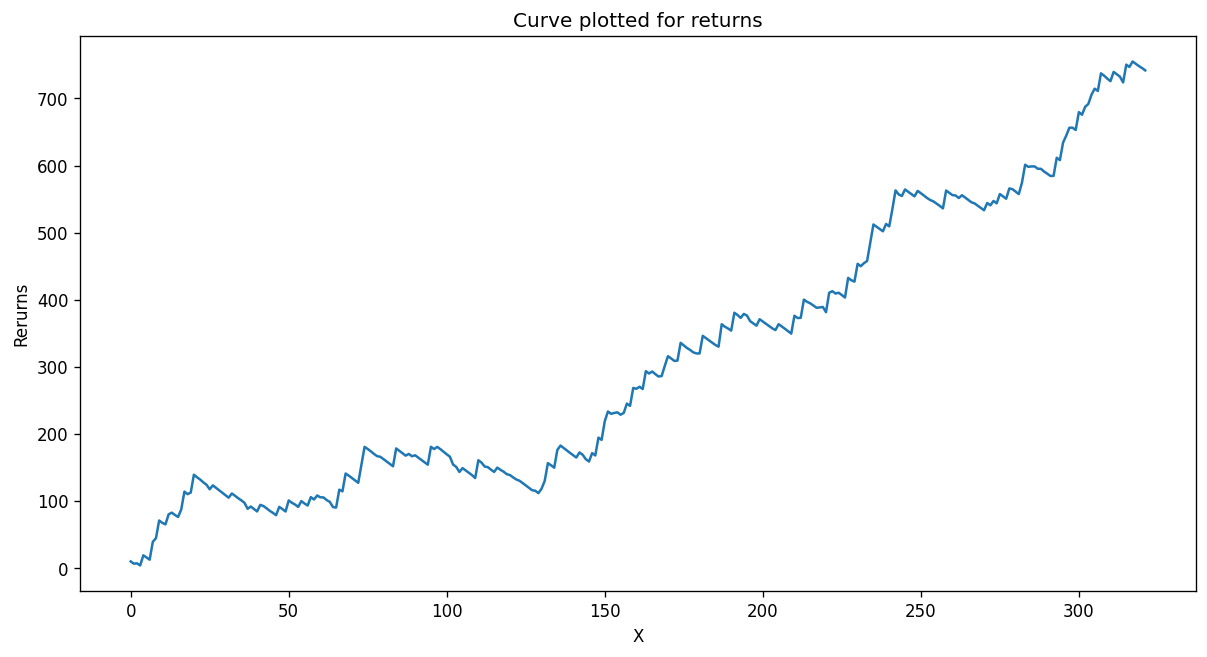

In [22]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

## Trades Analytics

In [23]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,Low_s1,High_s1,gap,max_gap_range_15,_3xlower_shadow,max_3xlower_shadow,min_3xlower_shadow,_3xupper_wick,max_3xupper_wick,min_3xupper_wick
0,1,6,104,915.07444,924.6,9.52556,0.010410,2020-11-09 09:05:00,2020-11-10 14:25:00,None,...,908.3,908.3,-1.4,2.0,-0.336,0.0,-0.3,-0.184,0.0,-0.2
1,-1,153,154,912.32622,915.7,-3.37378,-0.003698,2020-11-11 14:15:00,2020-11-11 14:20:00,None,...,914.5,917.9,0.0,0.0,-2.600,-0.9,-2.6,-2.384,1.2,-2.4
2,1,356,409,932.47966,933.0,0.52034,0.000558,2020-11-17 14:20:00,2020-11-18 14:30:00,None,...,928.8,931.5,0.0,0.0,-0.936,-0.9,-2.4,-0.973,-1.0,-2.3
3,-1,829,851,962.71110,965.9,-3.18890,-0.003312,2020-12-01 09:50:00,2020-12-01 13:05:00,None,...,962.0,963.5,0.0,5.0,-0.075,-0.1,-1.0,-0.200,-0.2,-0.9
4,1,856,1021,968.39043,983.5,15.10957,0.015603,2020-12-01 13:30:00,2020-12-04 14:30:00,None,...,966.6,967.3,0.0,0.0,-0.900,-0.1,-0.9,-0.892,0.1,-0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,1,53813,53927,1328.39840,1336.6,8.20160,0.006174,2025-02-04 13:45:00,2025-02-07 09:05:00,None,...,1326.2,1327.4,0.0,0.0,-0.899,0.3,-1.0,-0.557,-0.2,-0.8
318,-1,53988,53991,1327.50163,1331.0,-3.49837,-0.002635,2025-02-10 09:55:00,2025-02-10 10:10:00,None,...,1325.2,1327.8,0.0,10.0,-0.057,7.7,-4.6,-0.399,-0.3,-4.9
319,1,54082,54120,1341.10221,1337.7,-3.40221,-0.002537,2025-02-12 09:15:00,2025-02-12 13:50:00,None,...,1340.0,1340.7,0.0,0.0,-0.599,-0.1,-2.8,-0.536,0.0,-2.8
320,-1,54133,54156,1330.40076,1333.3,-2.89924,-0.002179,2025-02-13 09:15:00,2025-02-13 11:10:00,None,...,1330.9,1331.5,0.0,4.0,-0.473,-0.3,-0.5,-0.436,-0.3,-0.9


In [24]:
join_trades['down_from_max_10'] = join_trades['max_in_range'] - join_trades['Close'] 
join_trades['up_from_min_10'] = join_trades['Close'] -  join_trades['min_in_range']

In [25]:
join_trades['down_from_max_10_group'] = pd.qcut(join_trades.down_from_max_10, 20)
join_trades['up_from_min_10_group'] = pd.qcut(join_trades.up_from_min_10, 20)

In [26]:
join_trades['round_up_from_min_10'] = round(join_trades['up_from_min_10'])
join_trades['round_down_from_max_10'] = round(join_trades['down_from_max_10'])

In [27]:
long_trades = join_trades[join_trades.Size==1]
short_trades = join_trades[join_trades.Size==-1]

## max_3xlower_shadow and max_3xupper_wick ananlytics

<Axes: xlabel='max_3xlower_shadow'>

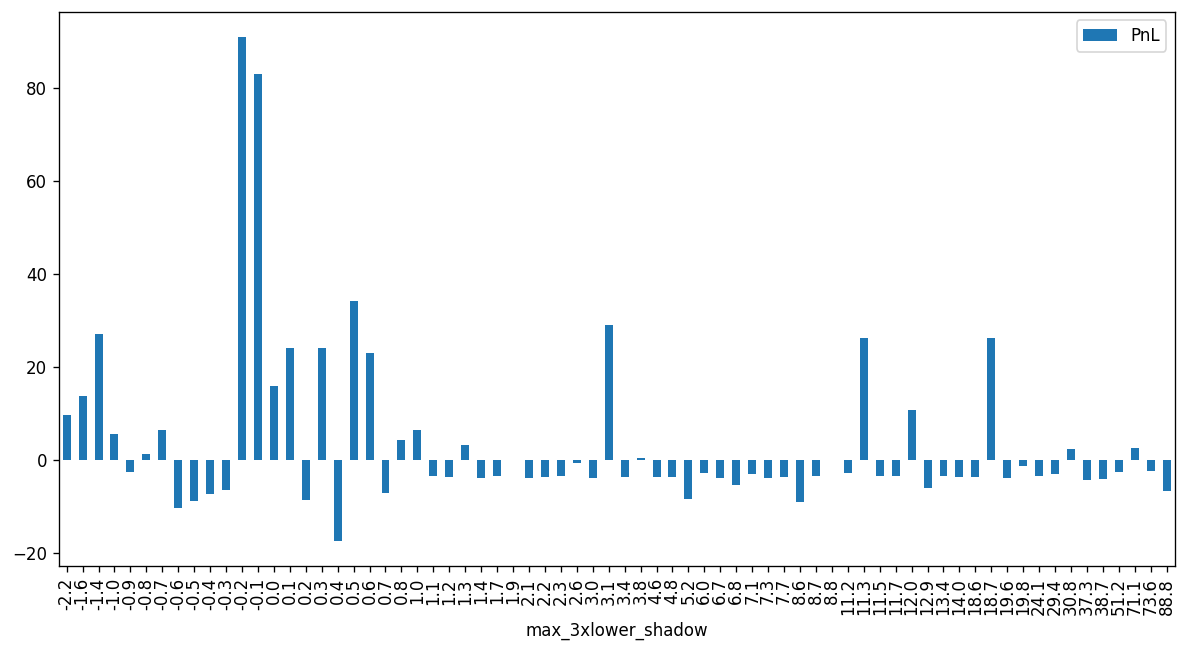

In [28]:
strades_grouped_by_max_3xshadow = short_trades.groupby(['max_3xlower_shadow'])[['PnL']].sum()
strades_grouped_by_max_3xshadow.plot.bar()

In [29]:
short_trades[short_trades.max_3xlower_shadow > 0.65]['PnL'].sum()

-34.79062999999644

<Axes: xlabel='min_3xlower_shadow'>

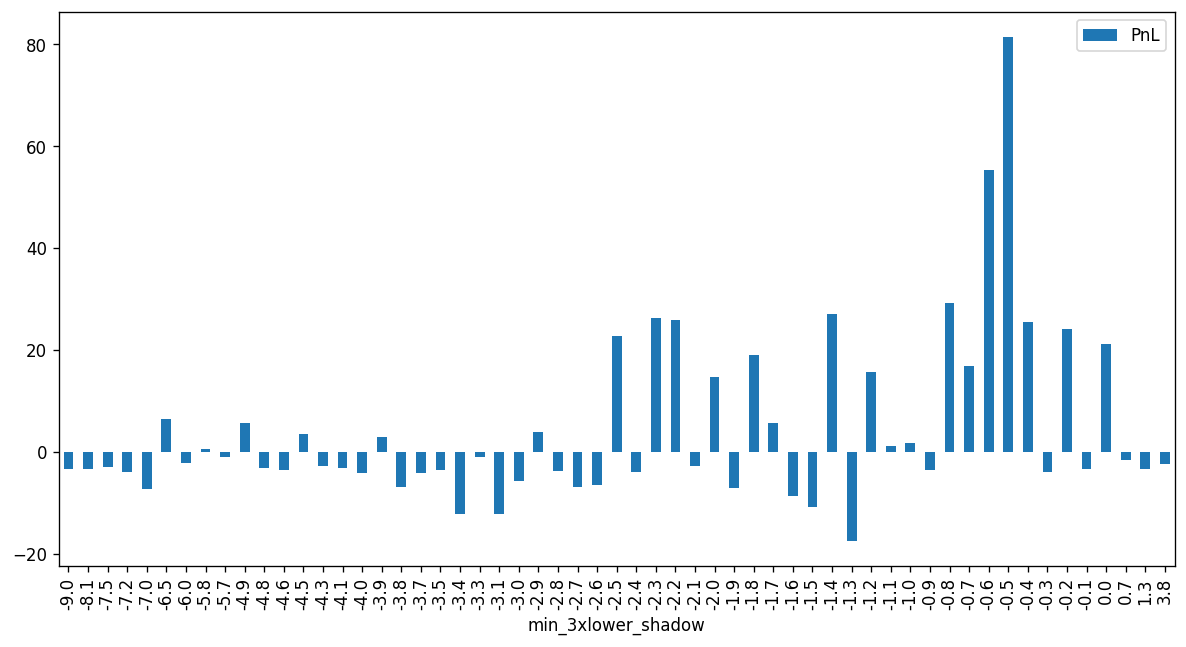

In [30]:
strades_grouped_by_min_3xshadow = short_trades.groupby(['min_3xlower_shadow'])[['PnL']].sum()
strades_grouped_by_min_3xshadow.plot.bar()

In [31]:
short_trades[(short_trades.min_3xlower_shadow < -2.55) | (short_trades.min_3xlower_shadow > 0.5)]['PnL'].sum()

-87.53757999999561

In [32]:
short_trades[(short_trades.min_3xlower_shadow < -2.55) | (short_trades.min_3xlower_shadow > 0.5)]['PnL'].count()

52

<Axes: xlabel='max_3xlower_shadow'>

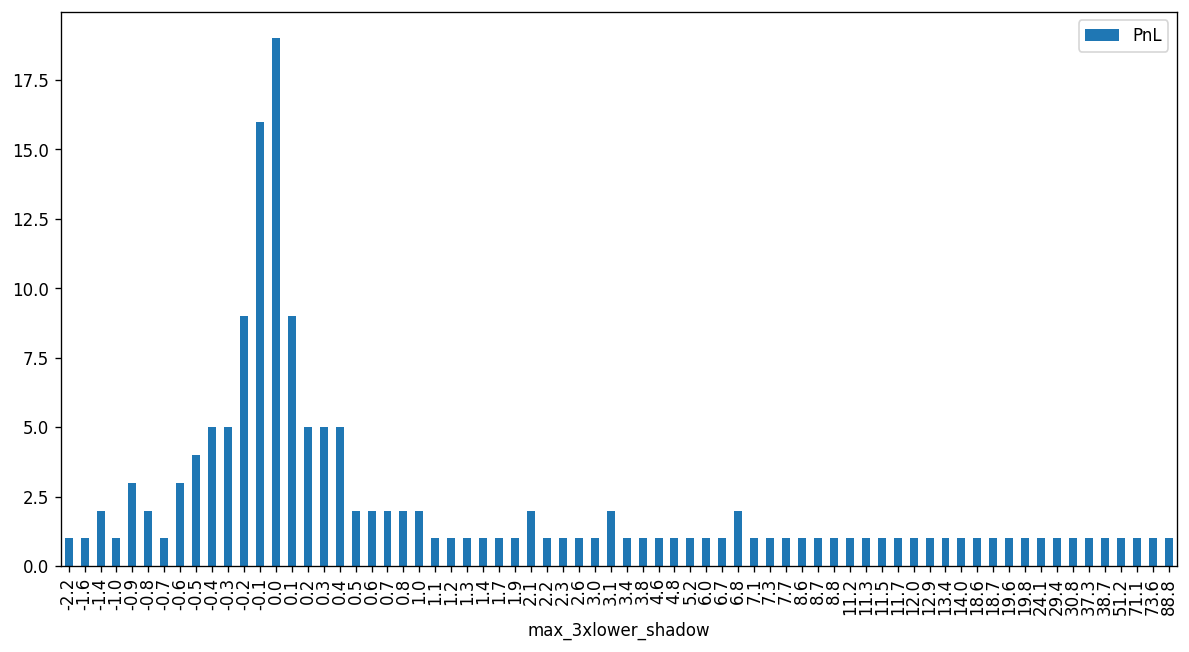

In [33]:
strades_grouped_by_max_3xshadowc = short_trades.groupby(['max_3xlower_shadow'])[['PnL']].count()
strades_grouped_by_max_3xshadowc.plot.bar()

<Axes: xlabel='max_3xupper_wick'>

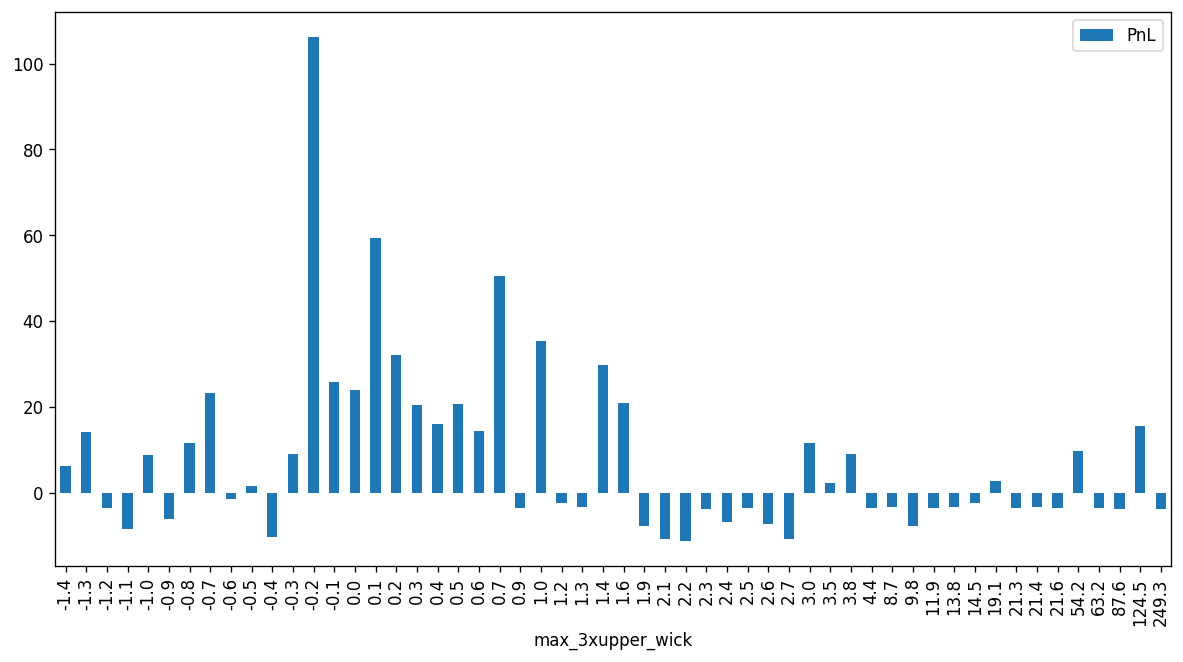

In [34]:
ltrades_grouped_by_max_3xwick = long_trades.groupby(['max_3xupper_wick'])[['PnL']].sum()
ltrades_grouped_by_max_3xwick.plot.bar()

In [35]:
long_trades[long_trades.max_3xupper_wick > 1.65]['PnL'].sum()

-58.48051999999666

In [36]:
long_trades[long_trades.max_3xupper_wick > 1.65]['PnL'].count()

37

<Axes: xlabel='min_3xupper_wick'>

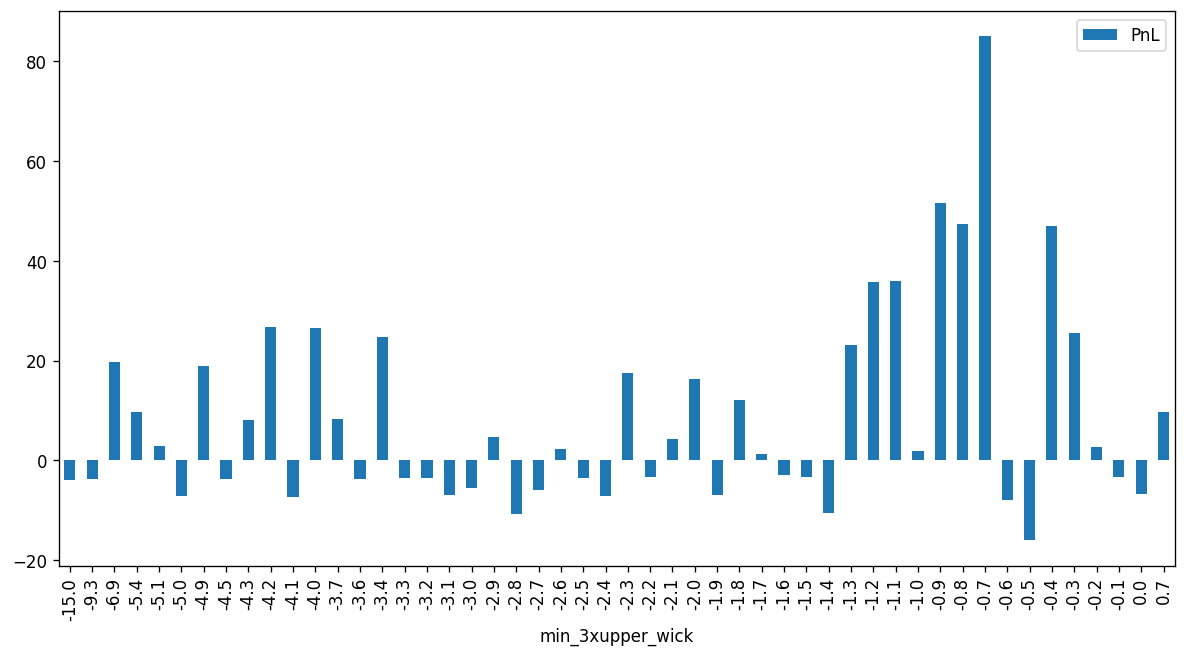

In [37]:
ltrades_grouped_by_min_3xwick = long_trades.groupby(['min_3xupper_wick'])[['PnL']].sum()
ltrades_grouped_by_min_3xwick.plot.bar()

In [38]:
long_trades[long_trades.min_3xupper_wick < -1.35]['PnL'].sum()

100.10406000000637

<Axes: xlabel='max_3xupper_wick'>

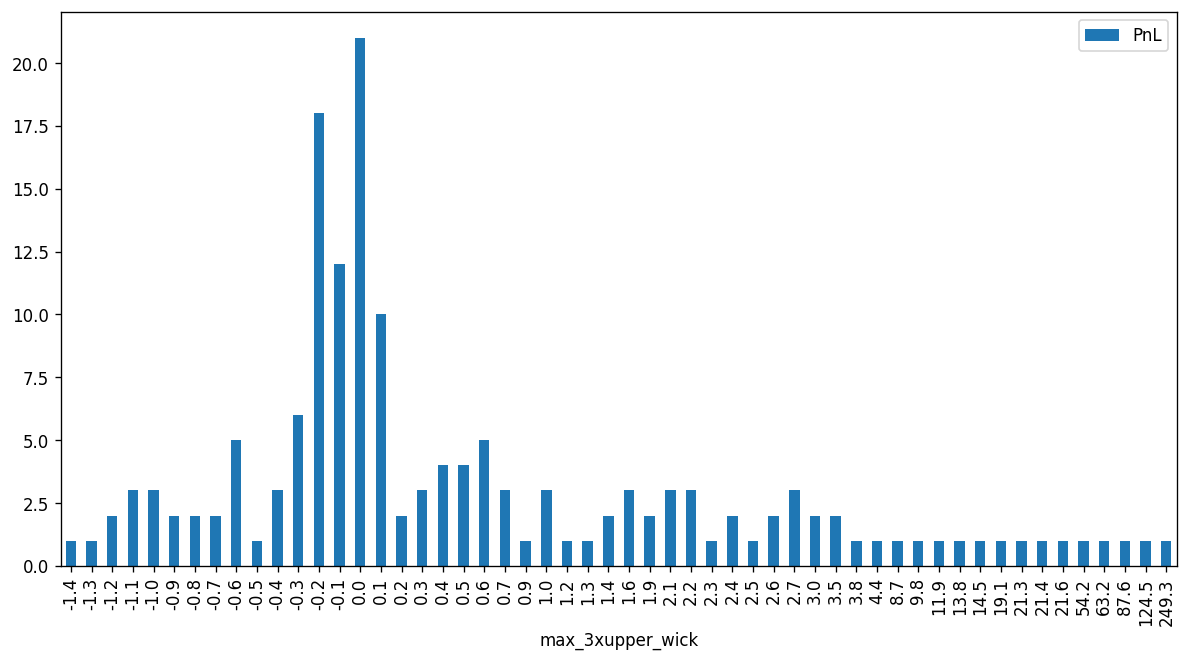

In [39]:
ltrades_grouped_by_min_3xwickc = long_trades.groupby(['max_3xupper_wick'])[['PnL']].count()
ltrades_grouped_by_min_3xwickc.plot.bar()

## Gap in range

<Axes: xlabel='max_gap_range_15'>

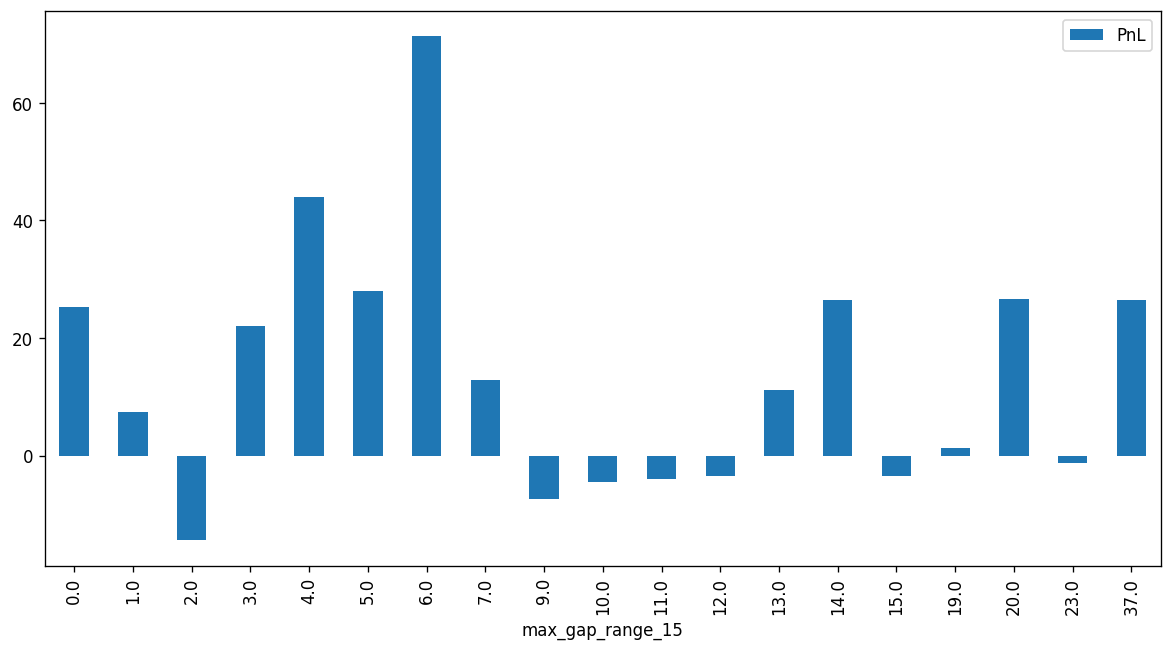

In [40]:
strades_grouped_by_gap = short_trades.groupby(['max_gap_range_15'])[['PnL']].sum()
strades_grouped_by_gap.plot.bar()

<Axes: xlabel='max_gap_range_15'>

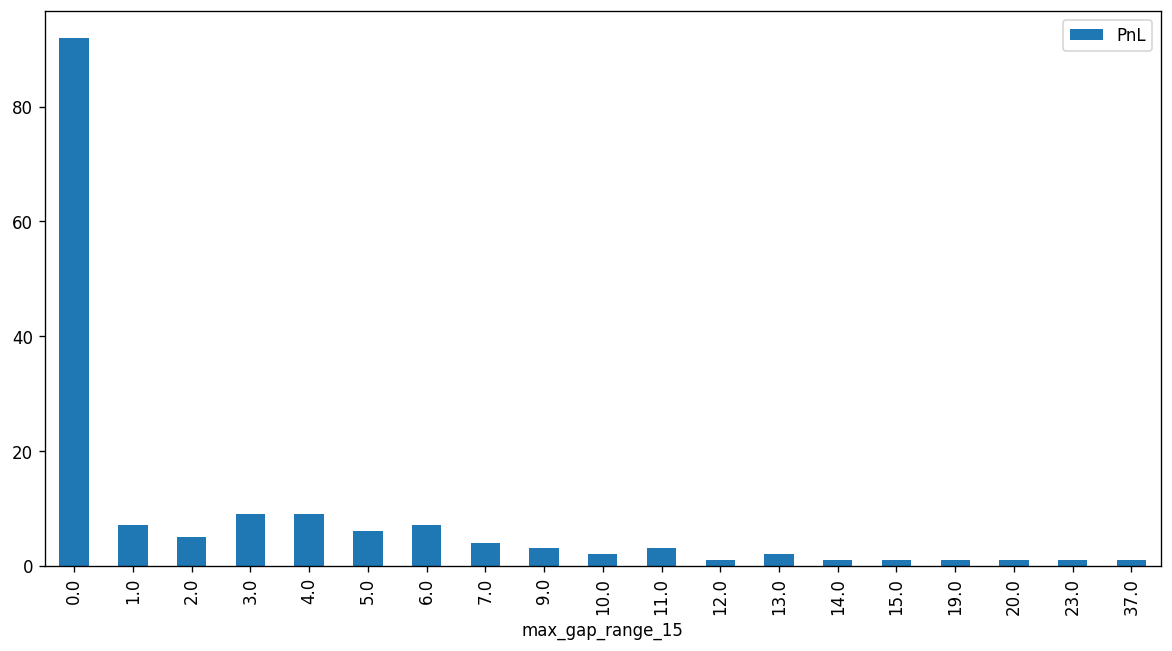

In [41]:
strades_grouped_by_gapc = short_trades.groupby(['max_gap_range_15'])[['PnL']].count()
strades_grouped_by_gapc.plot.bar()

## body_std_5 analytics

<Axes: xlabel='body_std_5'>

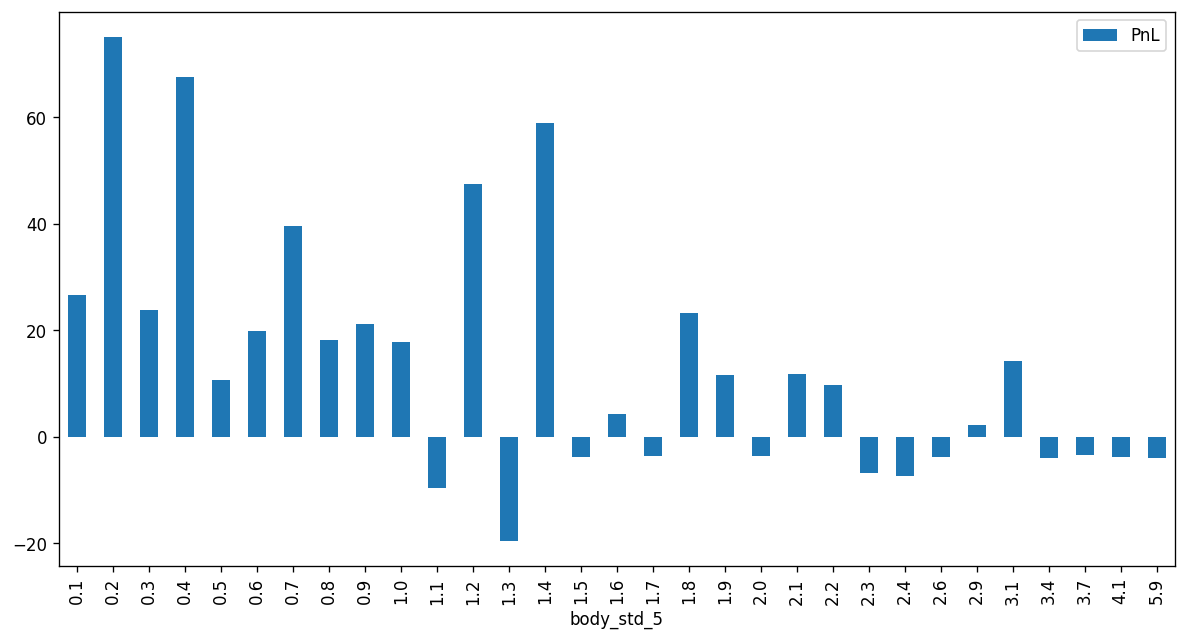

In [42]:
ltrades_grouped_by_body_std = long_trades.groupby(['body_std_5'])[['PnL']].sum()
ltrades_grouped_by_body_std.plot.bar()

## Upper wick & Lower shadow Analytics

<Axes: xlabel='max_3upper_wick'>

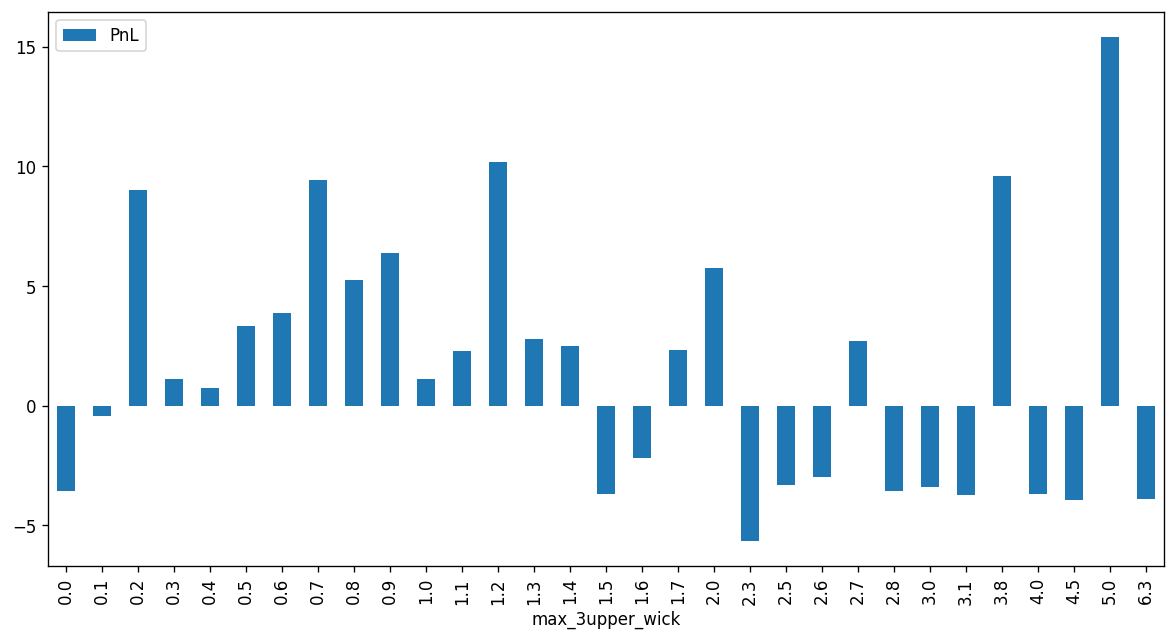

In [43]:
ltrades_grouped_by_max3wick = long_trades.groupby(['max_3upper_wick'])[['PnL']].mean()
ltrades_grouped_by_max3wick.plot.bar()

<Axes: xlabel='max_3upper_wick'>

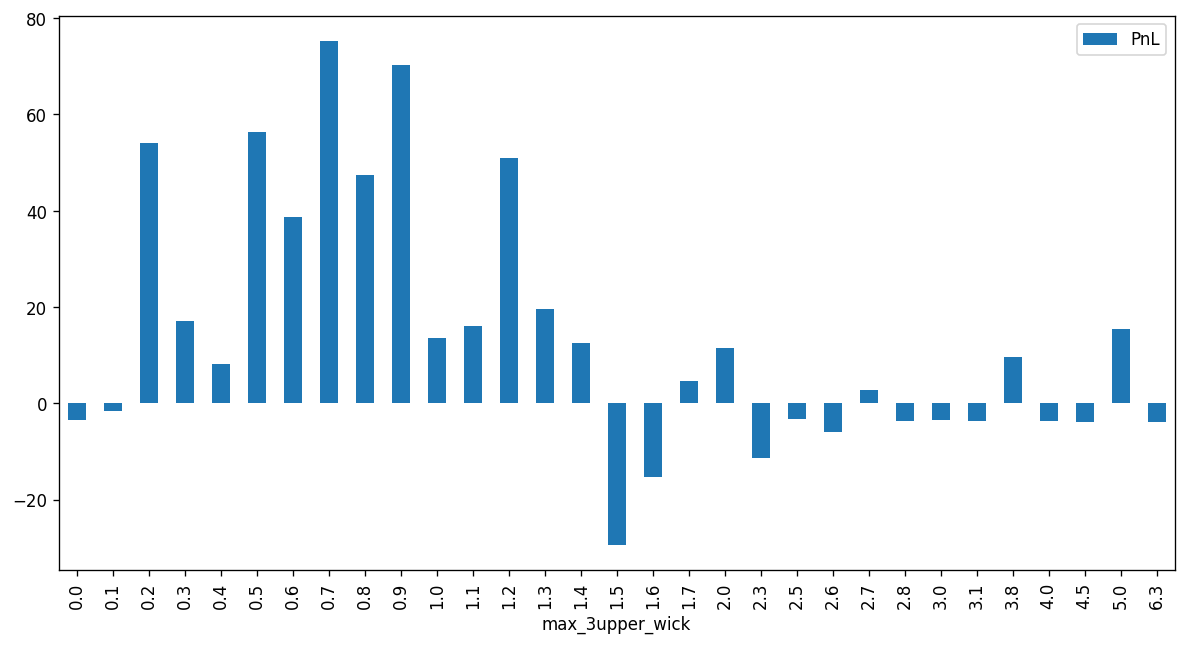

In [44]:
ltrades_grouped_by_max3wicks = long_trades.groupby(['max_3upper_wick'])[['PnL']].sum()
ltrades_grouped_by_max3wicks.plot.bar()

In [45]:
long_trades[long_trades.max_3upper_wick > 1.45]['PnL'].sum()

-43.56480999999735

<Axes: xlabel='max_3lower_shadow'>

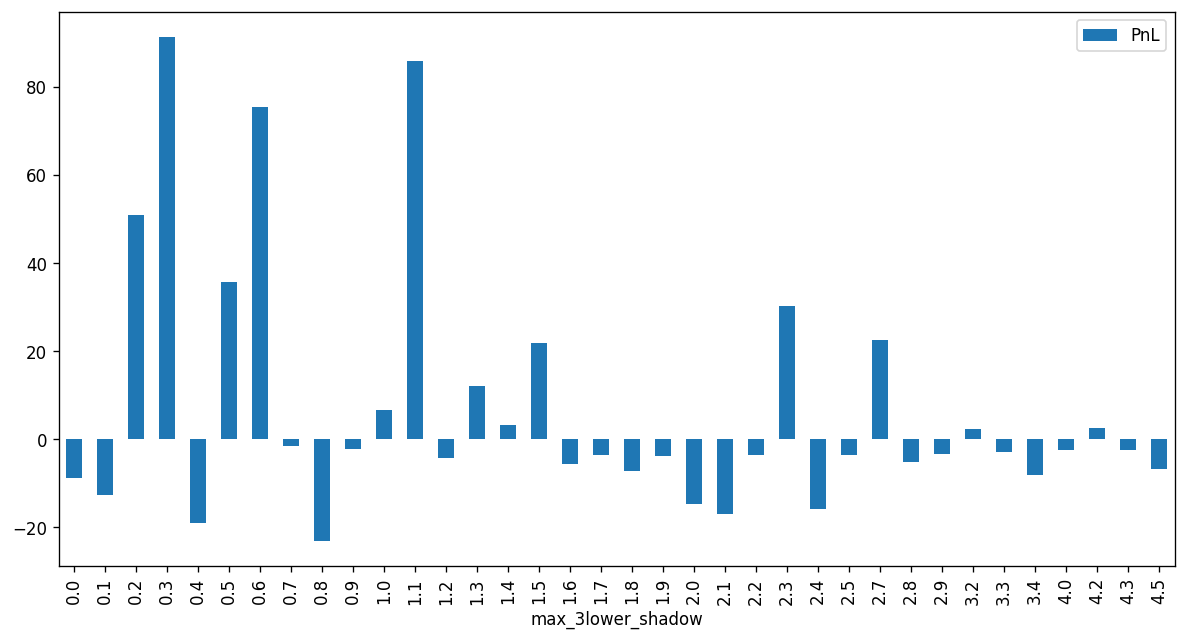

In [46]:
strades_grouped_by_max3shadow = short_trades.groupby(['max_3lower_shadow'])[['PnL']].sum()
strades_grouped_by_max3shadow.plot.bar()

In [47]:
short_trades[short_trades.max_3lower_shadow > 1.15]['PnL'].sum()

-14.793029999996293

<Axes: xlabel='min_3lower_shadow'>

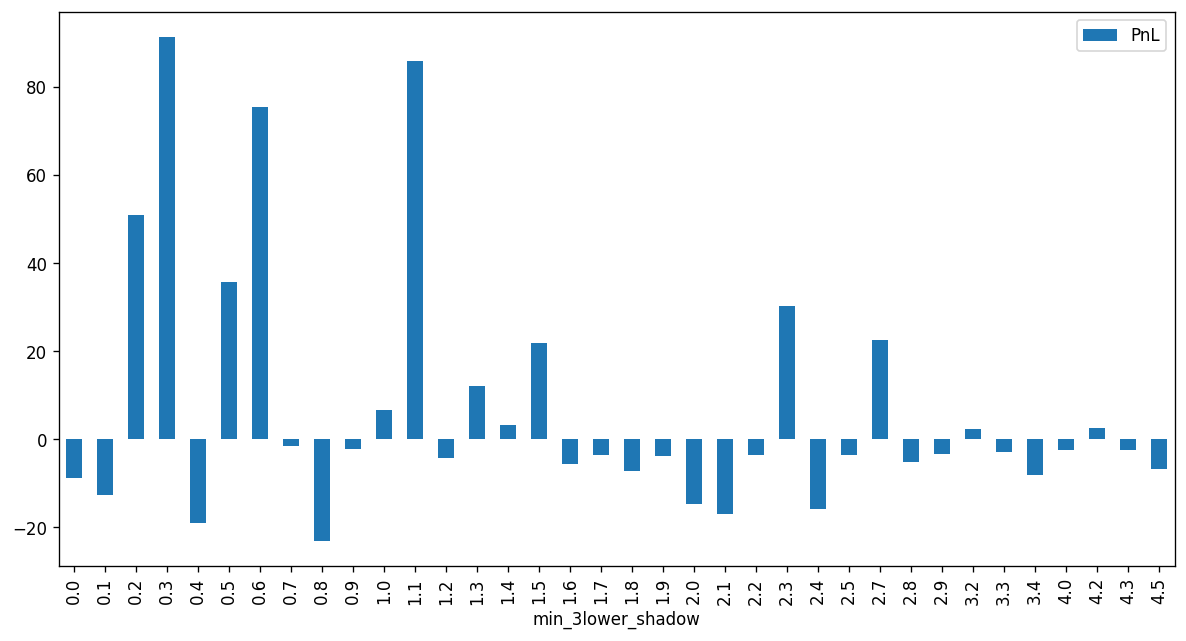

In [48]:
strades_grouped_by_min3shadow = short_trades.groupby(['min_3lower_shadow'])[['PnL']].sum()
strades_grouped_by_min3shadow.plot.bar()

In [49]:
short_trades[(short_trades.min_3lower_shadow < 0.15) |(short_trades.min_3lower_shadow > 1.65)]['PnL'].sum()

-63.31814999999676

<Axes: xlabel='max_3upper_wick'>

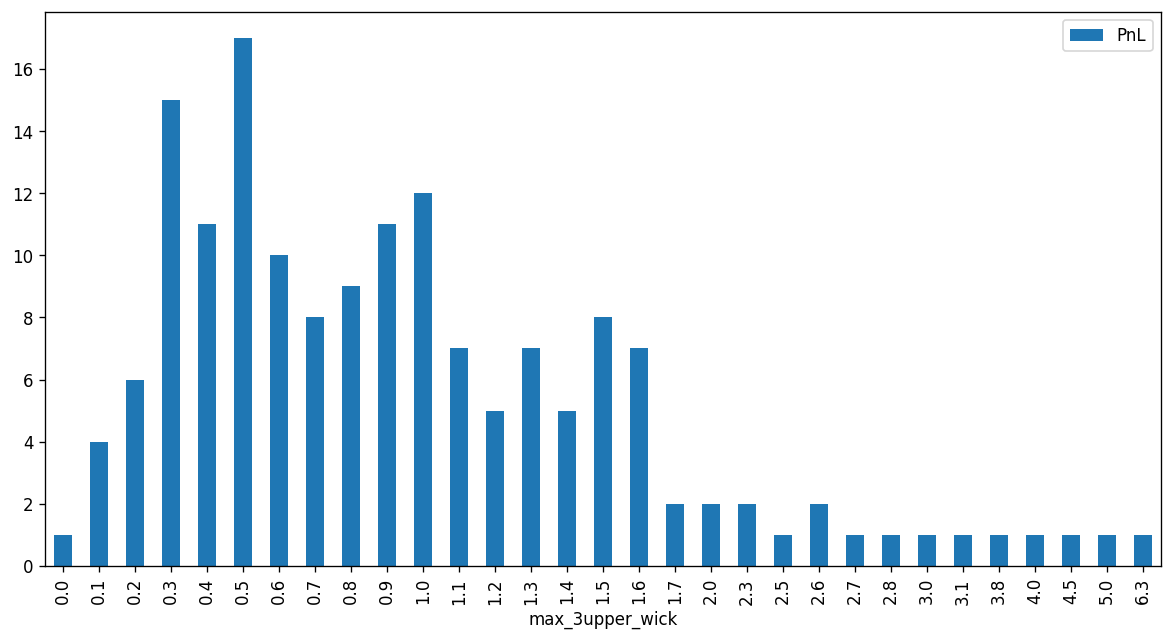

In [50]:
ltrades_grouped_by_max3wickc = long_trades.groupby(['max_3upper_wick'])[['PnL']].count()
ltrades_grouped_by_max3wickc.plot.bar()

## Max - Min 10 bars analytics

In [51]:
long_grpd_du = long_trades.groupby(['down_from_max_10_group', 'up_from_min_10_group'])[['PnL']]
long_irs_du = long_grpd_du.mean().reset_index()

In [52]:
import seaborn as sns

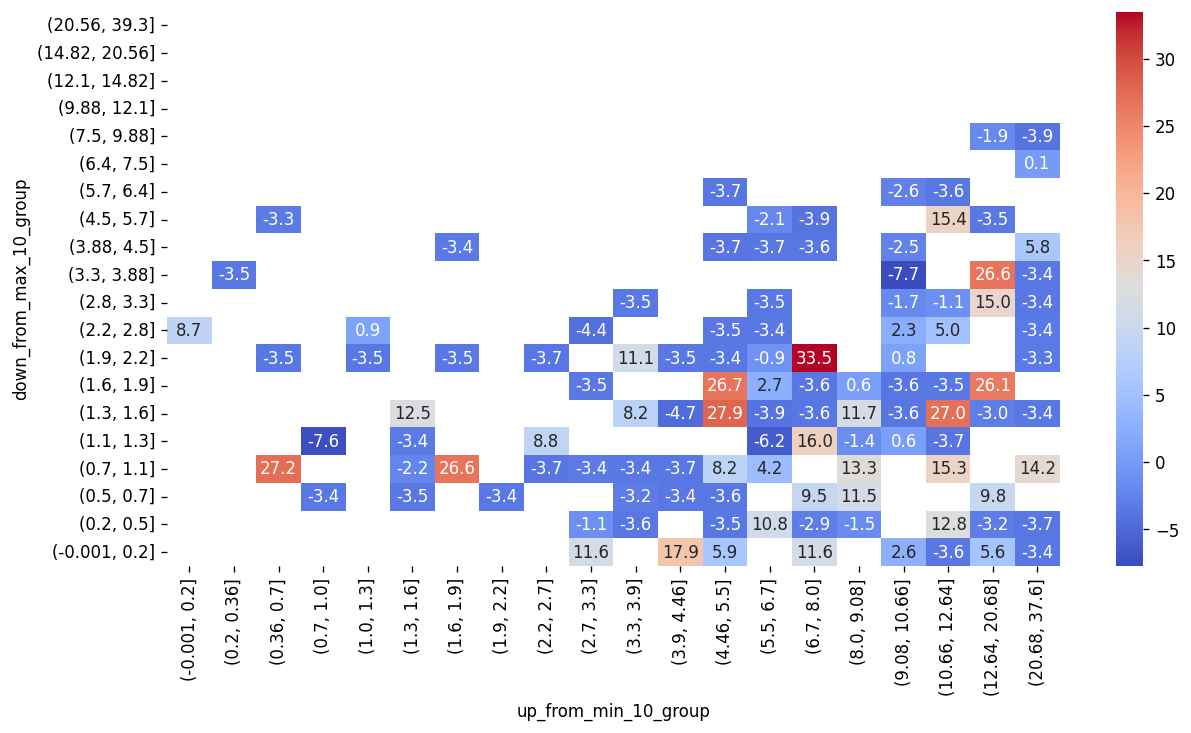

In [53]:
sns.heatmap(
    long_irs_du.pivot(index='down_from_max_10_group', columns='up_from_min_10_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True, fmt=".1f");

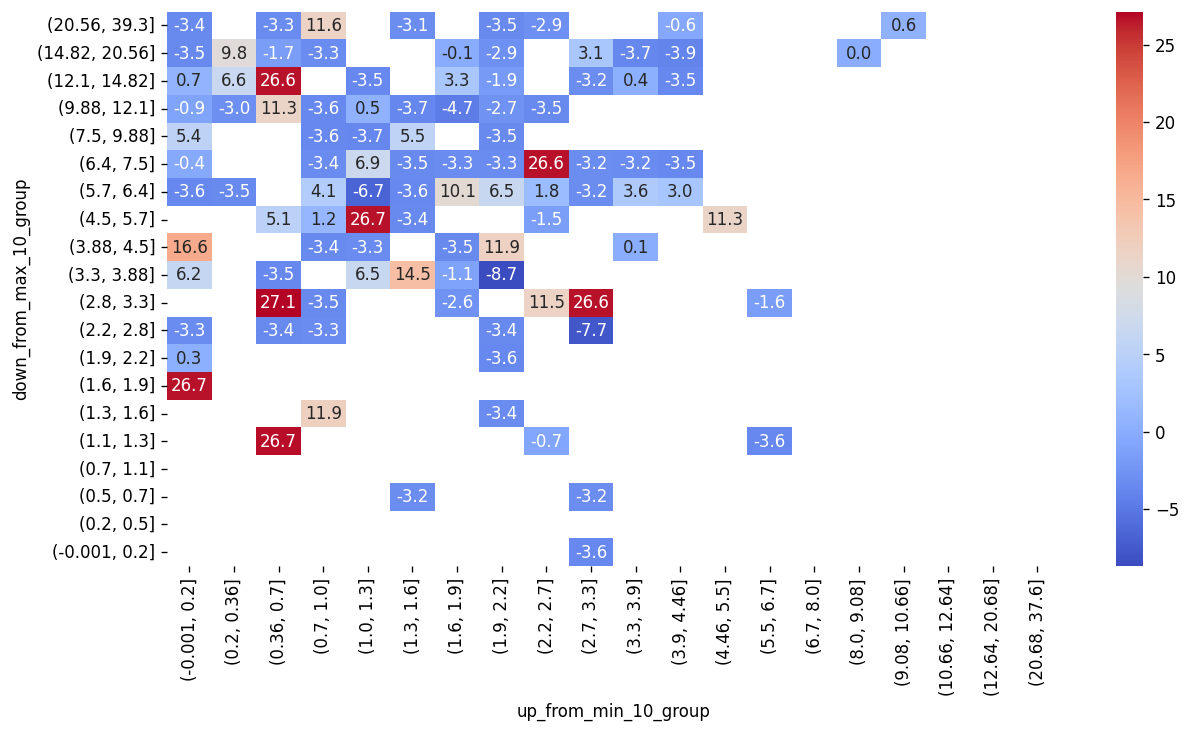

In [54]:
short_grpd_du = short_trades.groupby(['down_from_max_10_group', 'up_from_min_10_group'])[['PnL']]
short_irs_du = short_grpd_du.mean().reset_index()
sns.heatmap(
    short_irs_du.pivot(index='down_from_max_10_group', columns='up_from_min_10_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True, fmt=".1f");

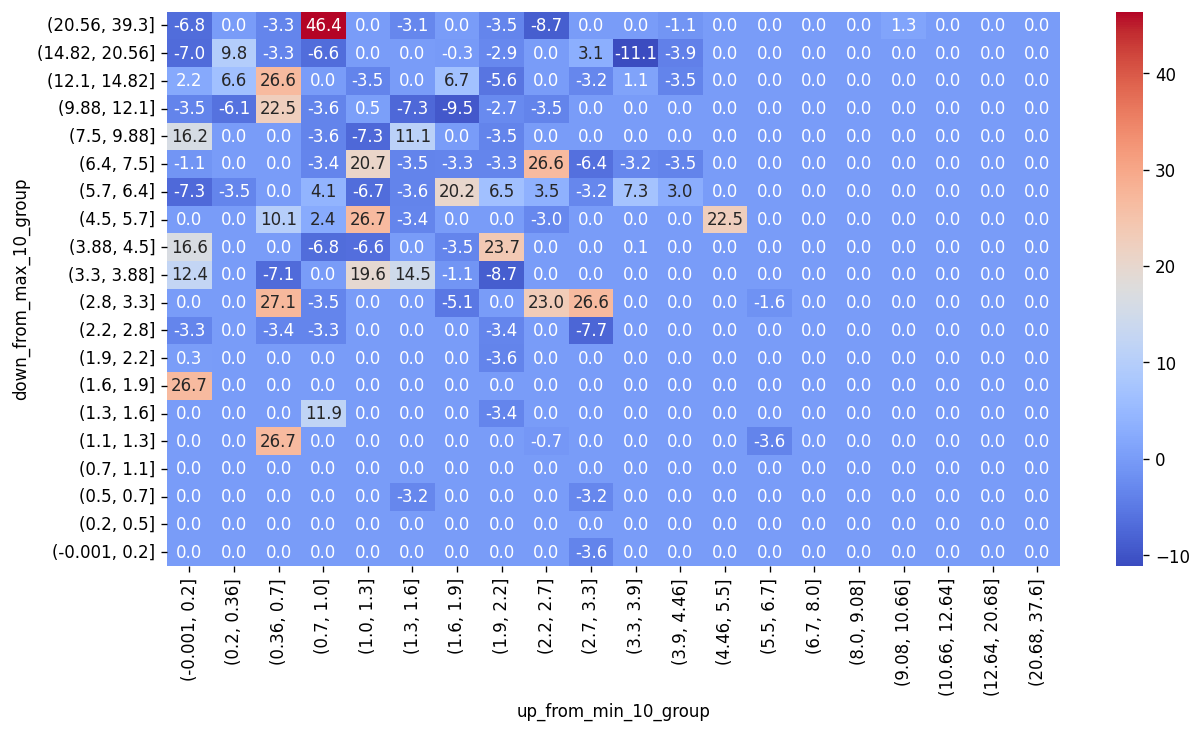

In [55]:
short_irs_du2 = short_grpd_du.sum().reset_index()
sns.heatmap(
    short_irs_du2.pivot(index='down_from_max_10_group', columns='up_from_min_10_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True, fmt=".1f");

<Axes: xlabel='round_up_from_min_10'>

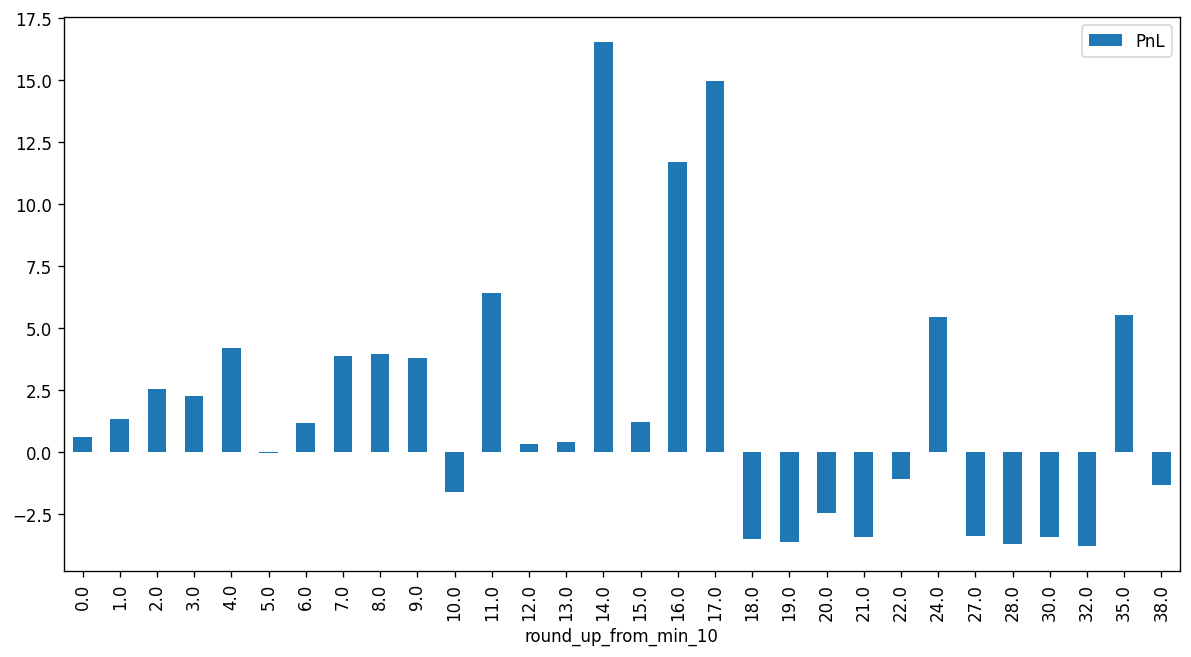

In [56]:
ltrades_grouped_by_round_upfmin = long_trades.groupby(['round_up_from_min_10'])[['PnL']].mean()
ltrades_grouped_by_round_upfmin.plot.bar()

<Axes: xlabel='round_down_from_max_10'>

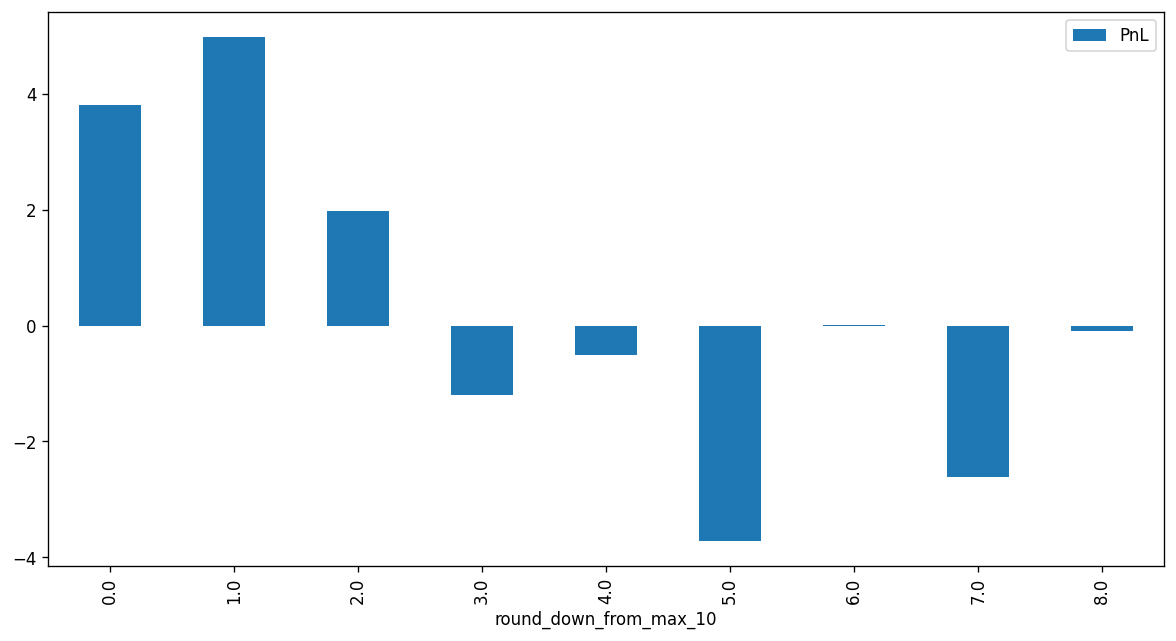

In [57]:
ltrades_grouped_by_round_downfmax = long_trades.groupby(['round_down_from_max_10'])[['PnL']].mean()
ltrades_grouped_by_round_downfmax.plot.bar()

<Axes: xlabel='round_up_from_min_10'>

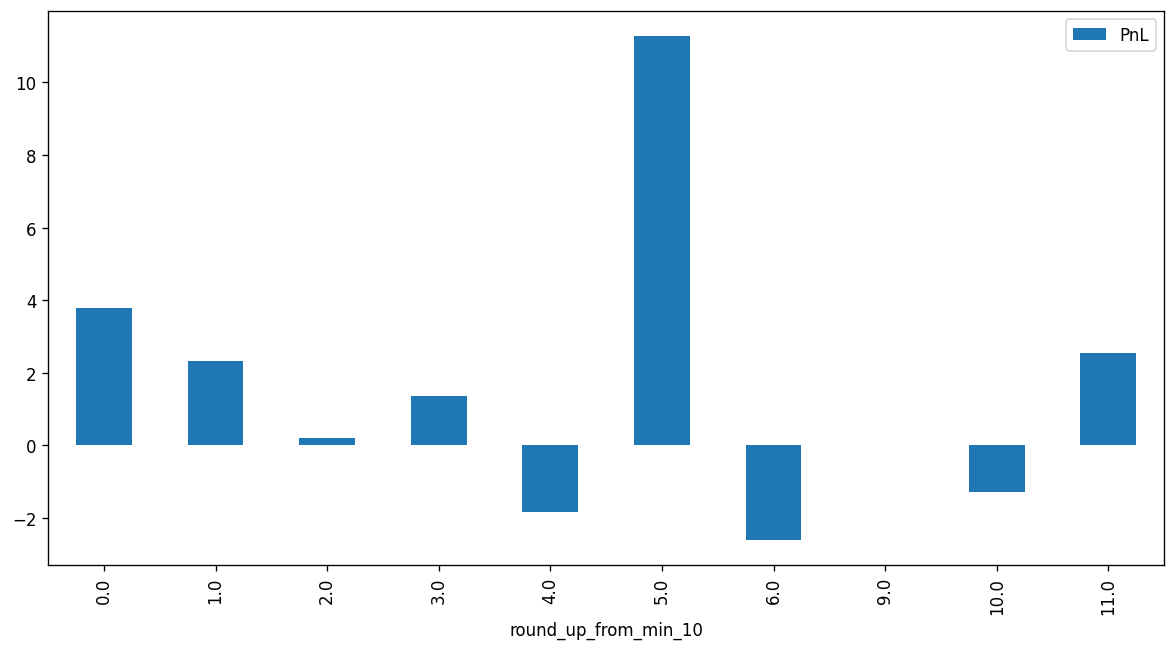

In [58]:
strades_grouped_by_round_upfmin = short_trades.groupby(['round_up_from_min_10'])[['PnL']].mean()
strades_grouped_by_round_upfmin.plot.bar()

<Axes: xlabel='round_down_from_max_10'>

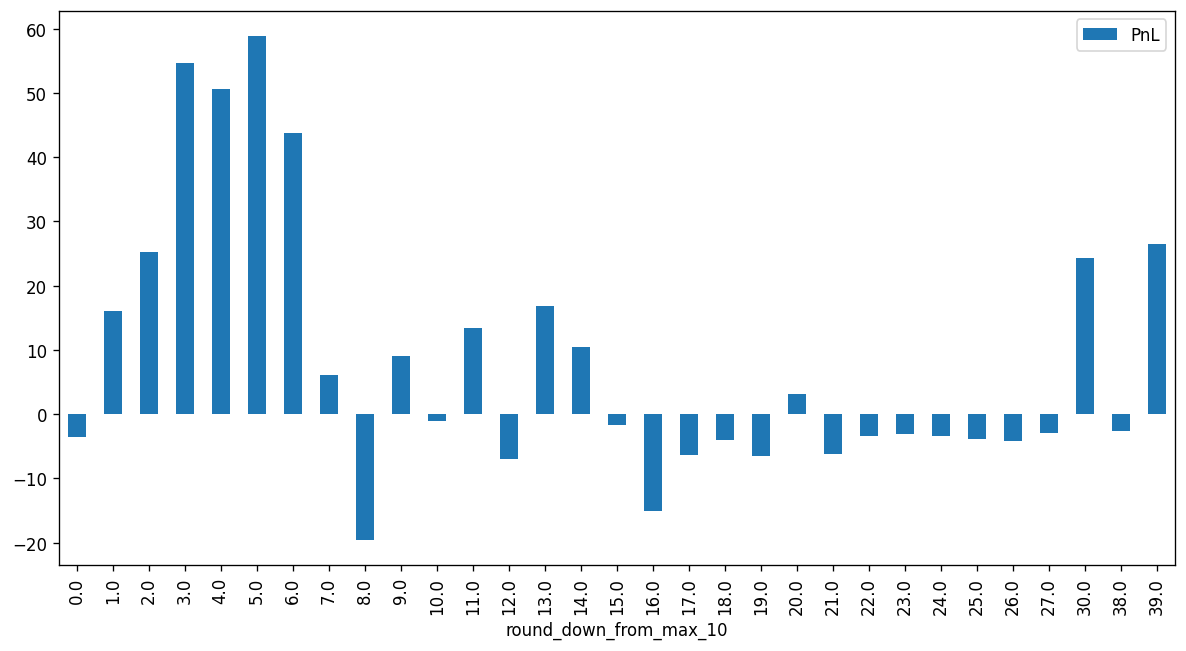

In [59]:
strades_grouped_by_round_downfmax = short_trades.groupby(['round_down_from_max_10'])[['PnL']].sum()
strades_grouped_by_round_downfmax.plot.bar()

<Axes: xlabel='round_down_from_max_10'>

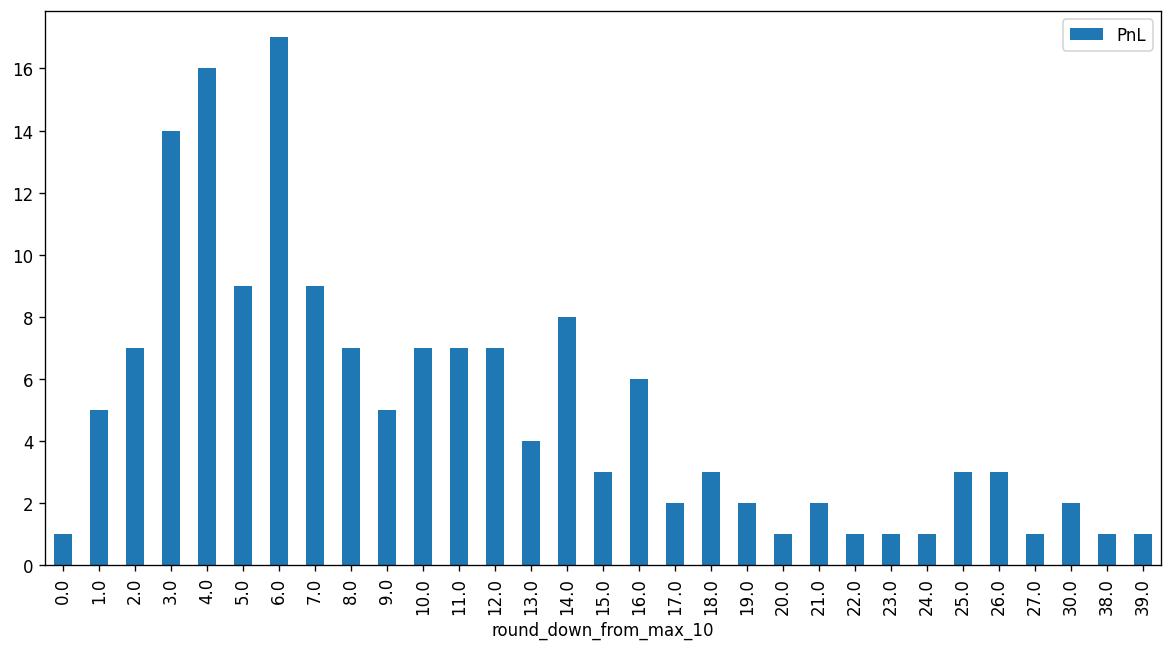

In [60]:
strades_grouped_by_round_downfmax_count = short_trades.groupby(['round_down_from_max_10'])[['PnL']].count()
strades_grouped_by_round_downfmax_count.plot.bar()

## Mix IBS vs min-max10

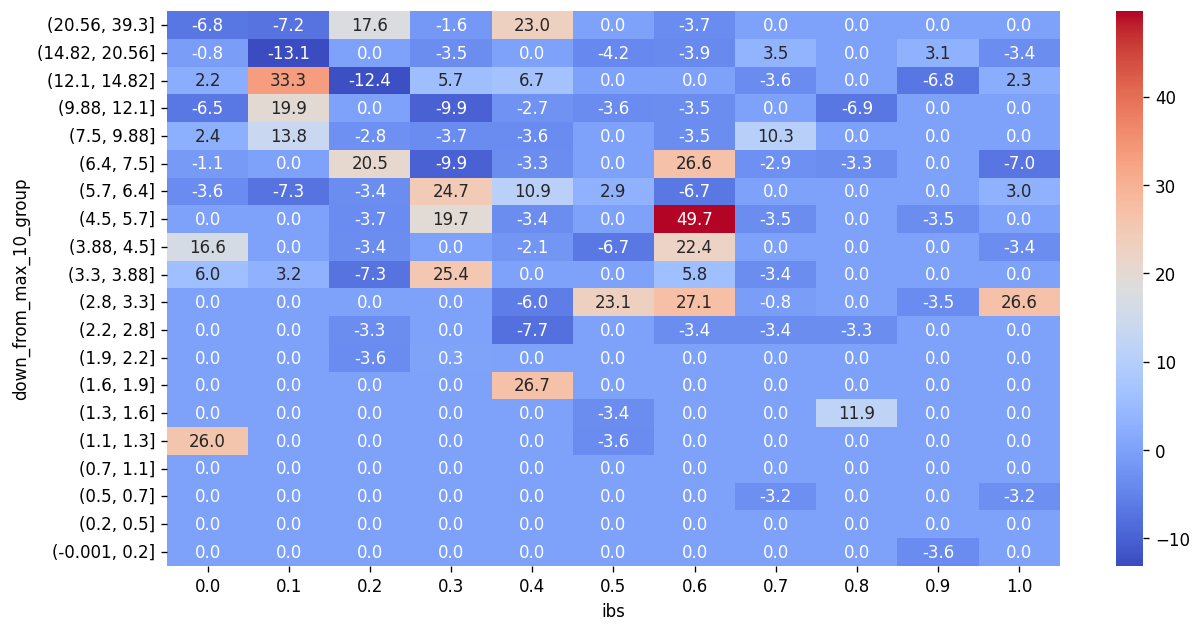

In [61]:
short_grpd_imax = short_trades.groupby(['down_from_max_10_group', 'ibs'])[['PnL']]
short_irs_imax = short_grpd_imax.sum().reset_index()
sns.heatmap(
    short_irs_imax.pivot(index='down_from_max_10_group', columns='ibs', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True, fmt=".1f");

## RSI Analytics

<Axes: xlabel='RSI'>

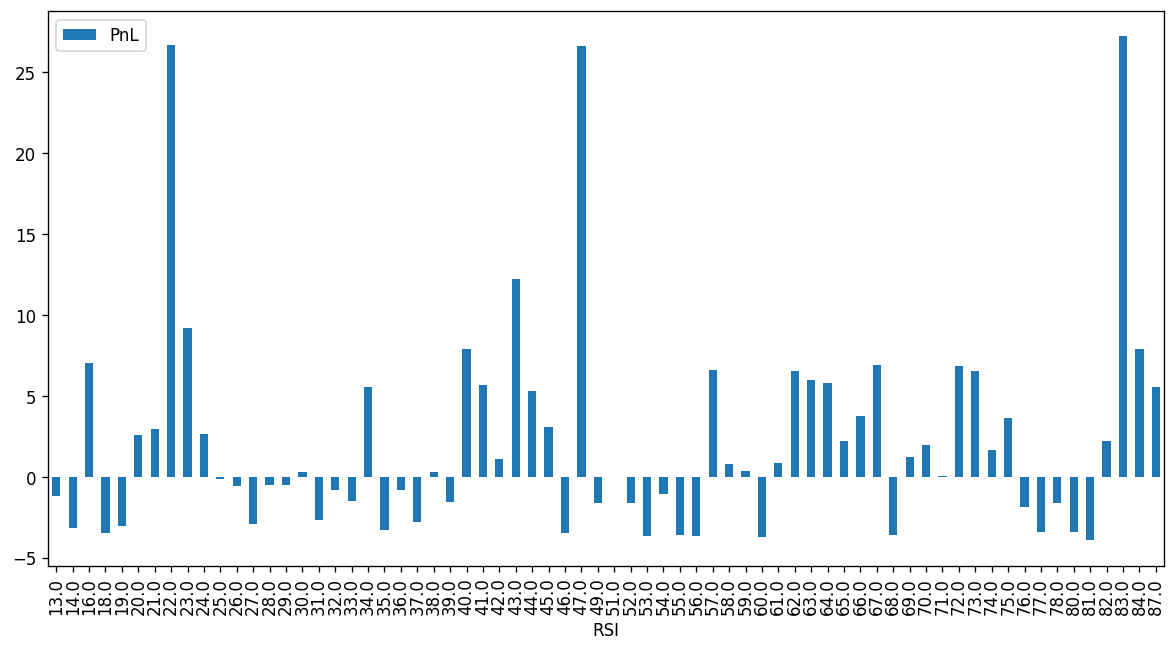

In [62]:
trades_grouped_by_rsi = join_trades.groupby(['RSI'])[['PnL']].mean()
trades_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI'>

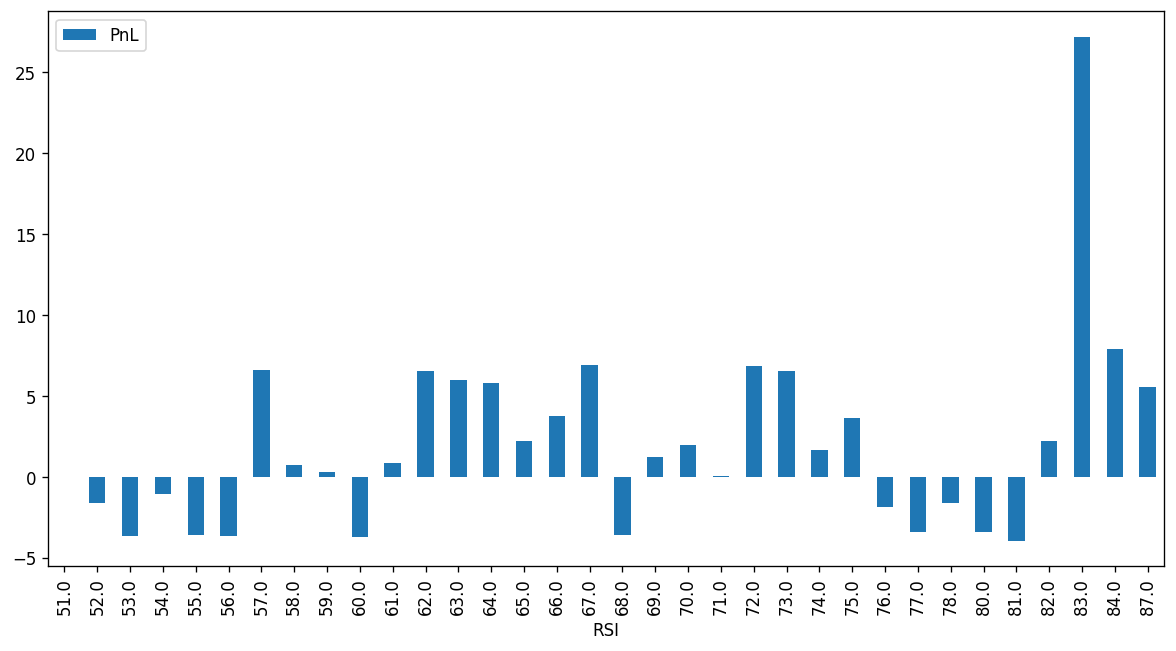

In [63]:
long_trades_grouped_by_rsi = long_trades.groupby(['RSI'])[['PnL']].mean()
long_trades_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI'>

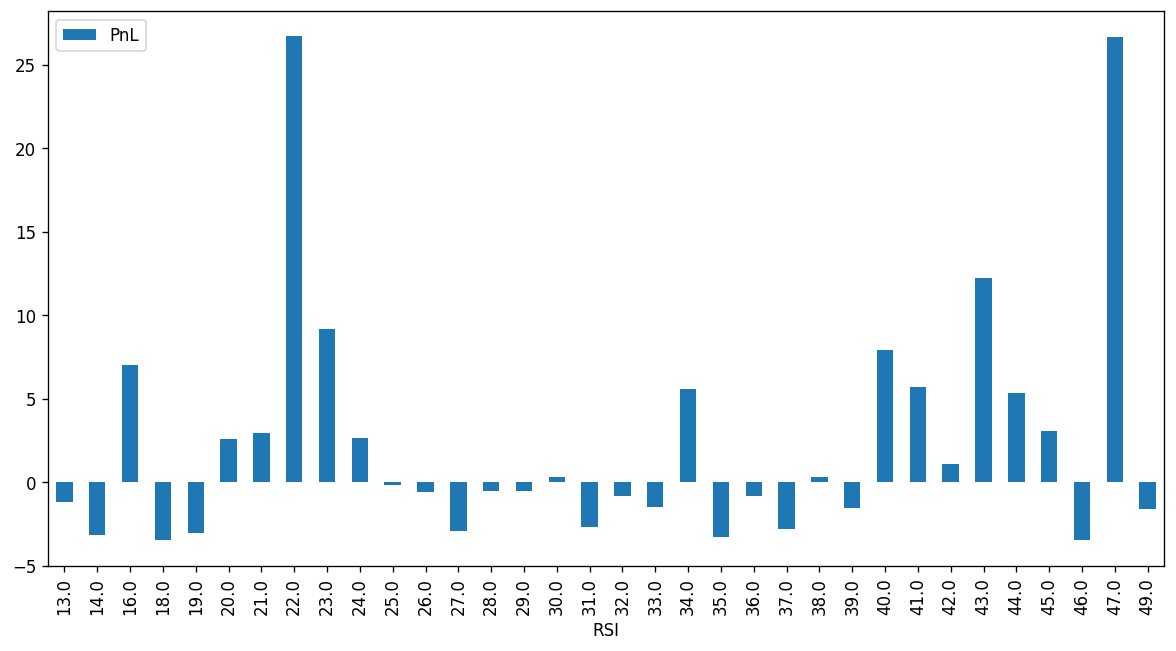

In [64]:
short_trades_grouped_by_rsi = short_trades.groupby(['RSI'])[['PnL']].mean()
short_trades_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI'>

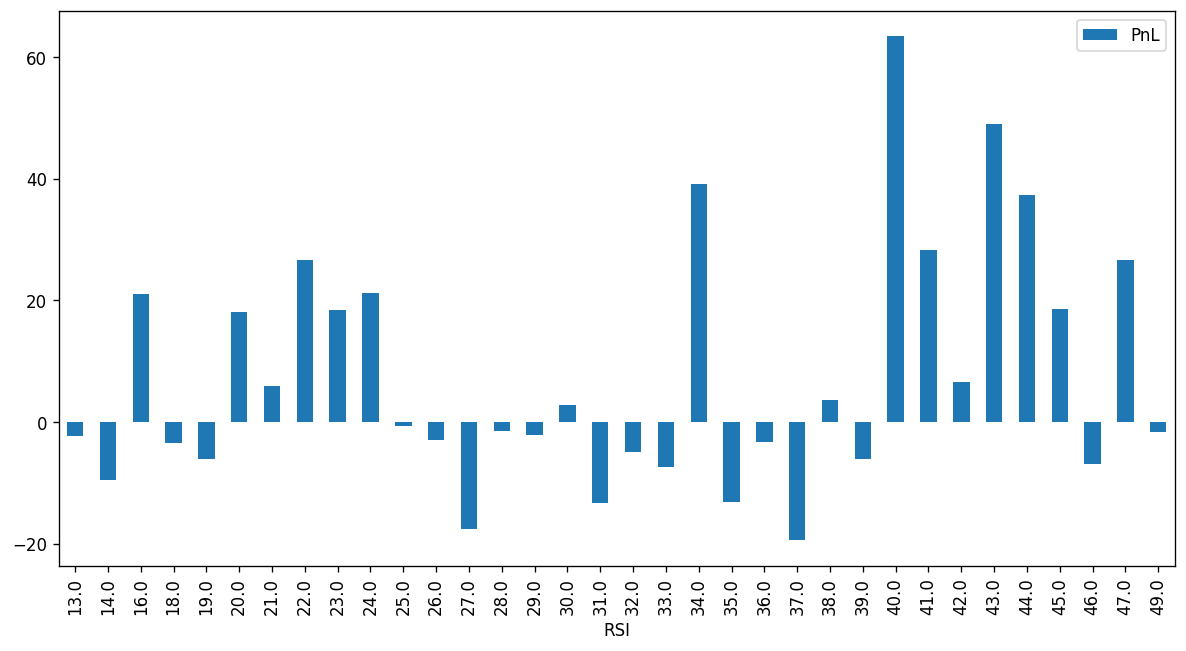

In [65]:
short_trades_grouped_by_rsi_sum = short_trades.groupby(['RSI'])[['PnL']].sum()
short_trades_grouped_by_rsi_sum.plot.bar()

<Axes: xlabel='RSI'>

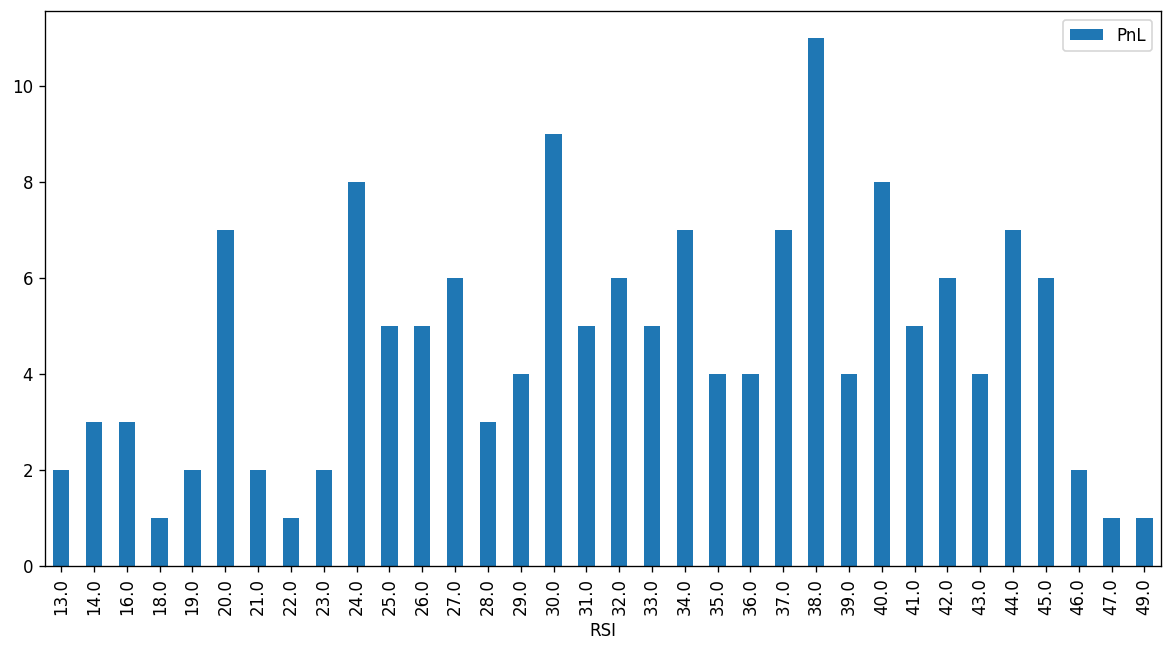

In [66]:
short_trades_grouped_by_rsi_count = short_trades.groupby(['RSI'])[['PnL']].count()
short_trades_grouped_by_rsi_count.plot.bar()

## Price move & ATR ananlytics

<Axes: xlabel='ATR_5'>

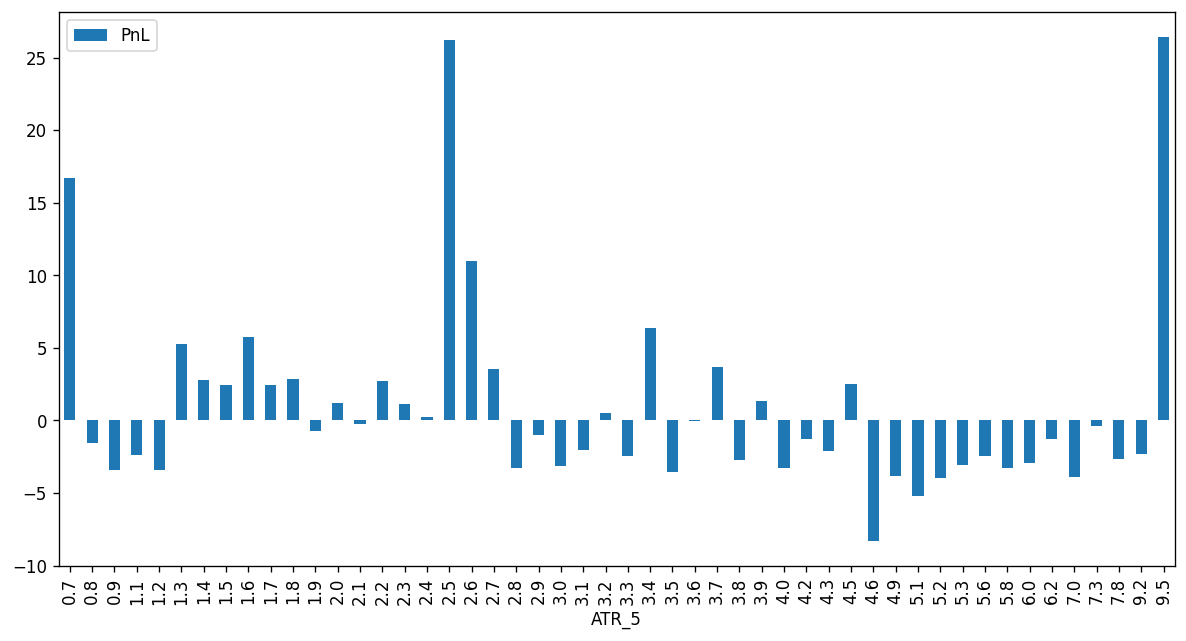

In [67]:
short_trades_grouped_by_atr5 = short_trades.groupby(['ATR_5'])[['PnL']].mean()
short_trades_grouped_by_atr5.plot.bar()

<Axes: xlabel='ATR_5'>

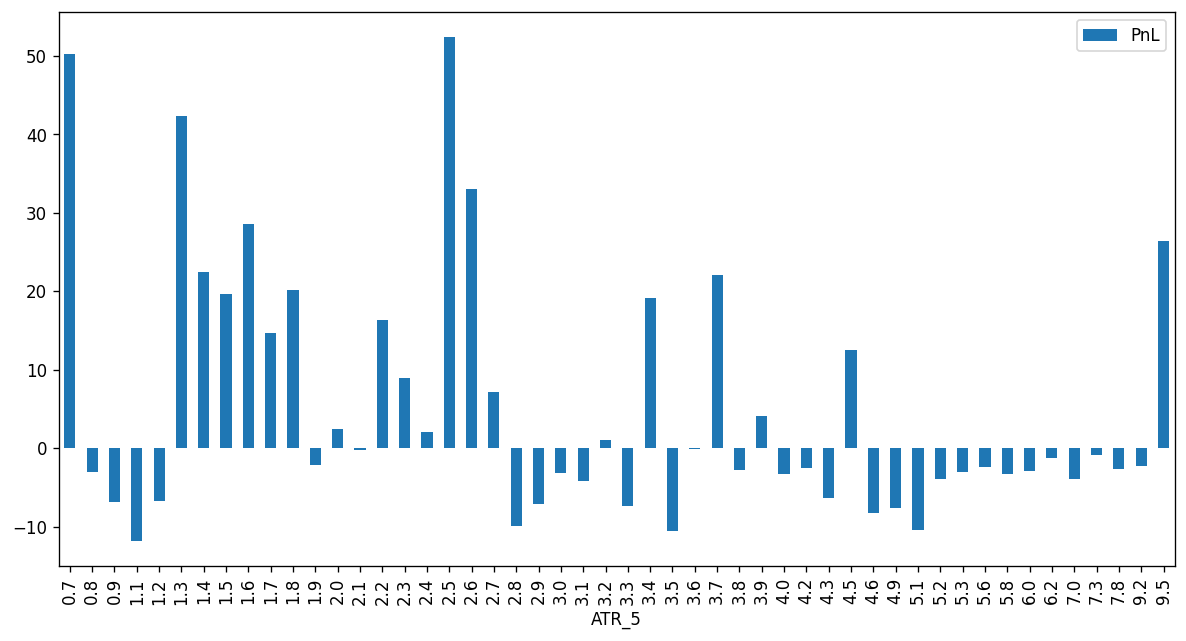

In [68]:
short_trades_grouped_by_atr5_sum = short_trades.groupby(['ATR_5'])[['PnL']].sum()
short_trades_grouped_by_atr5_sum.plot.bar()

<Axes: xlabel='ATR_5'>

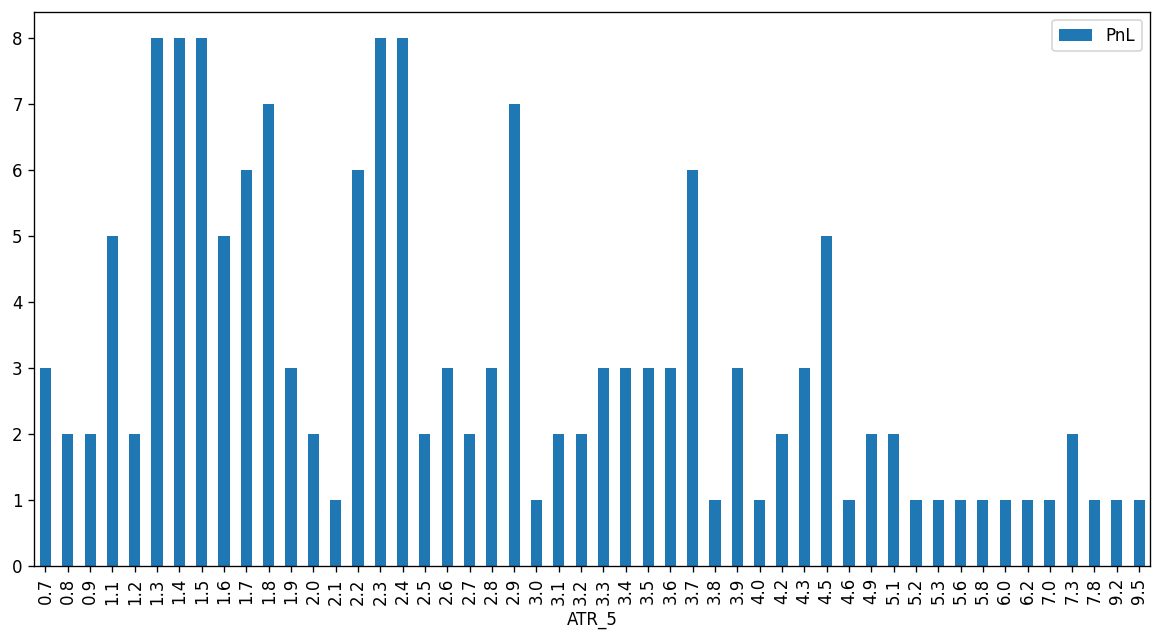

In [69]:
short_trades_grouped_by_atr5_count = short_trades.groupby(['ATR_5'])[['PnL']].count()
short_trades_grouped_by_atr5_count.plot.bar()

Text(0, 0.5, 'PnL')

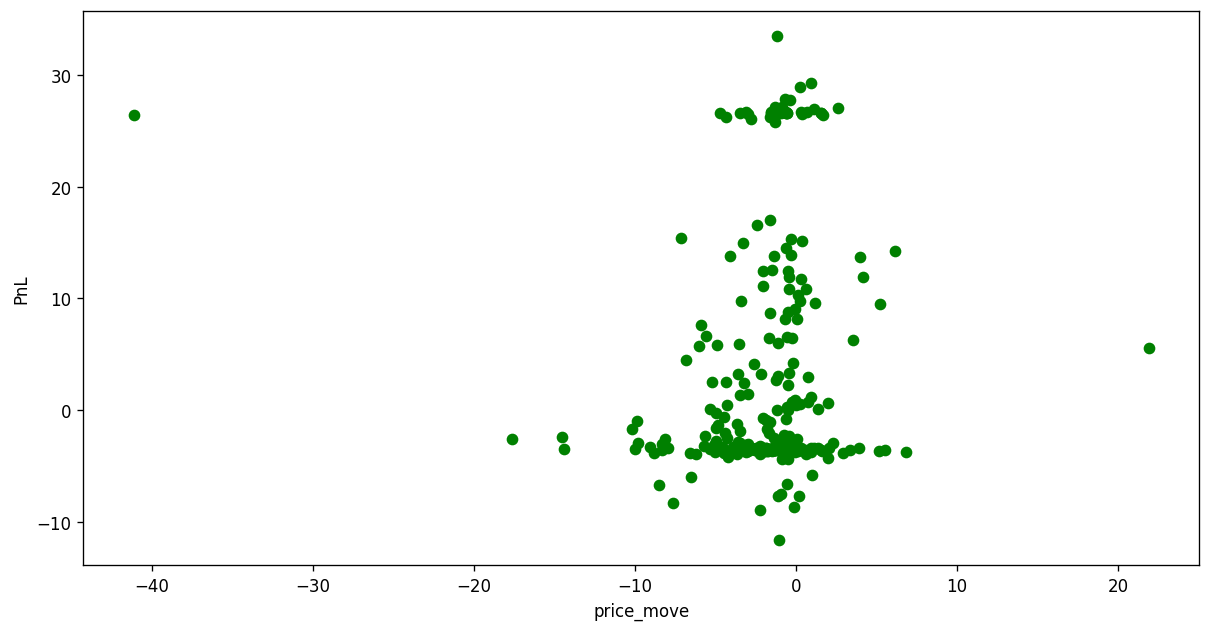

In [70]:
plt.scatter(join_trades['price_move'], join_trades['PnL'], color='green')
plt.xlabel("price_move")
plt.ylabel("PnL")

<Axes: xlabel='price_move_round'>

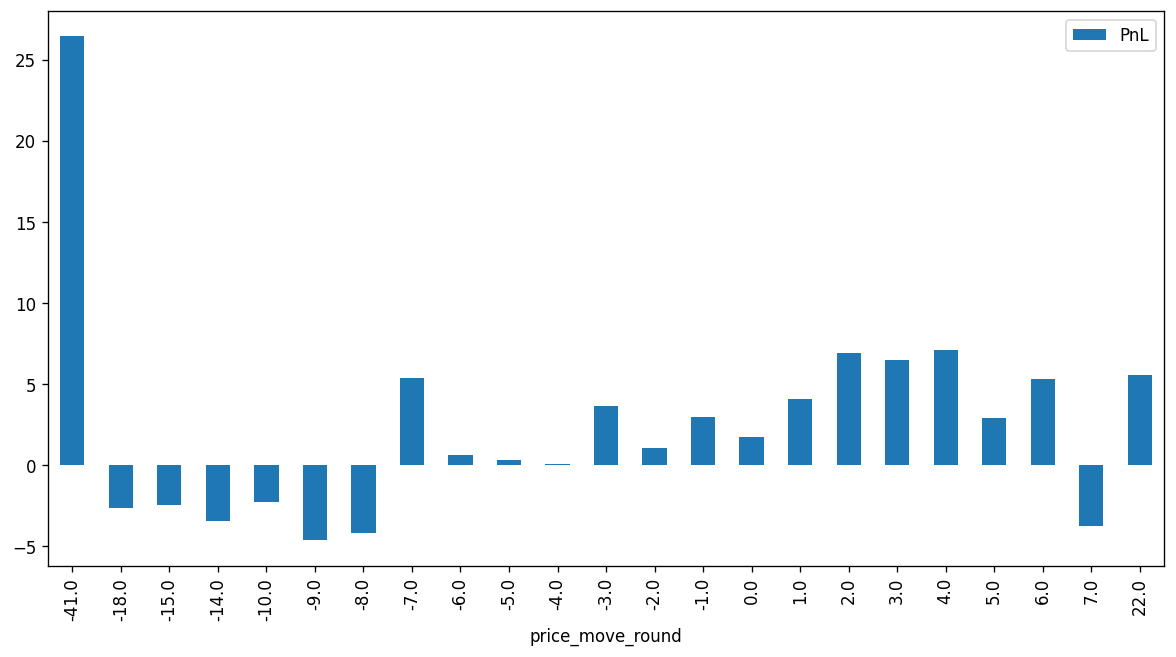

In [71]:
trades_grouped_by_pricemove = join_trades.groupby(['price_move_round'])[['PnL']].mean()
trades_grouped_by_pricemove.plot.bar()

<Axes: xlabel='price_move_round'>

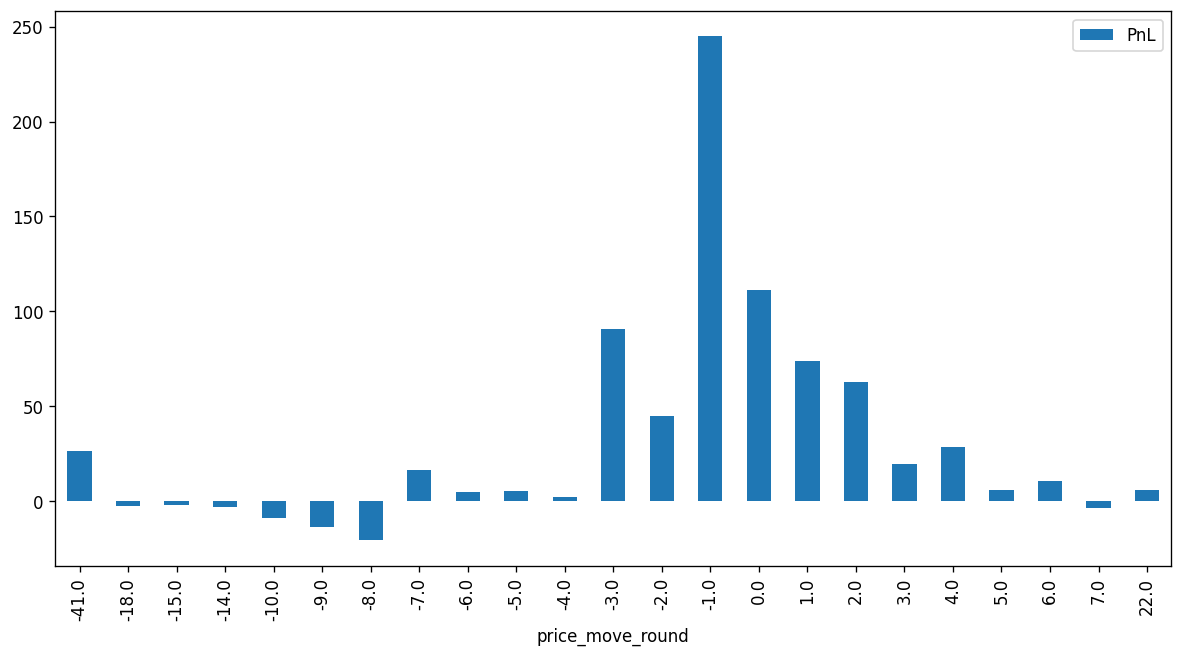

In [72]:
trades_grouped_by_pricemove_sum = join_trades.groupby(['price_move_round'])[['PnL']].sum()
trades_grouped_by_pricemove_sum.plot.bar()

<Axes: xlabel='price_move_round'>

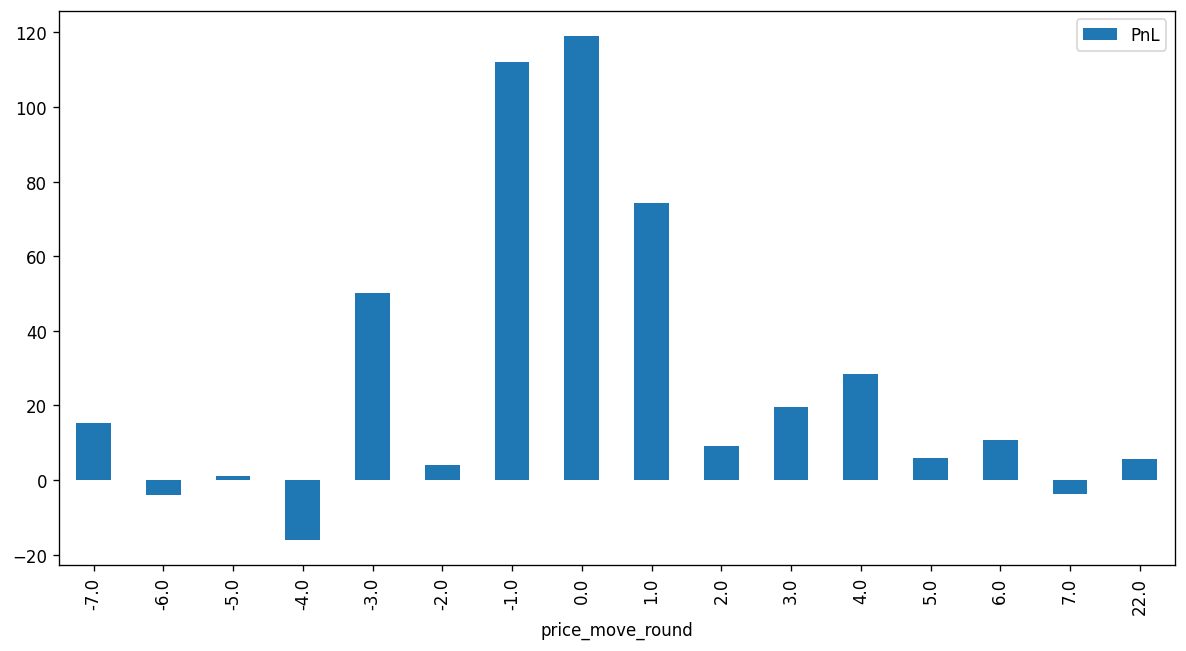

In [73]:
long_trades_grouped_by_pricemove_sum = long_trades.groupby(['price_move_round'])[['PnL']].sum()
long_trades_grouped_by_pricemove_sum.plot.bar()

<Axes: xlabel='price_move_round'>

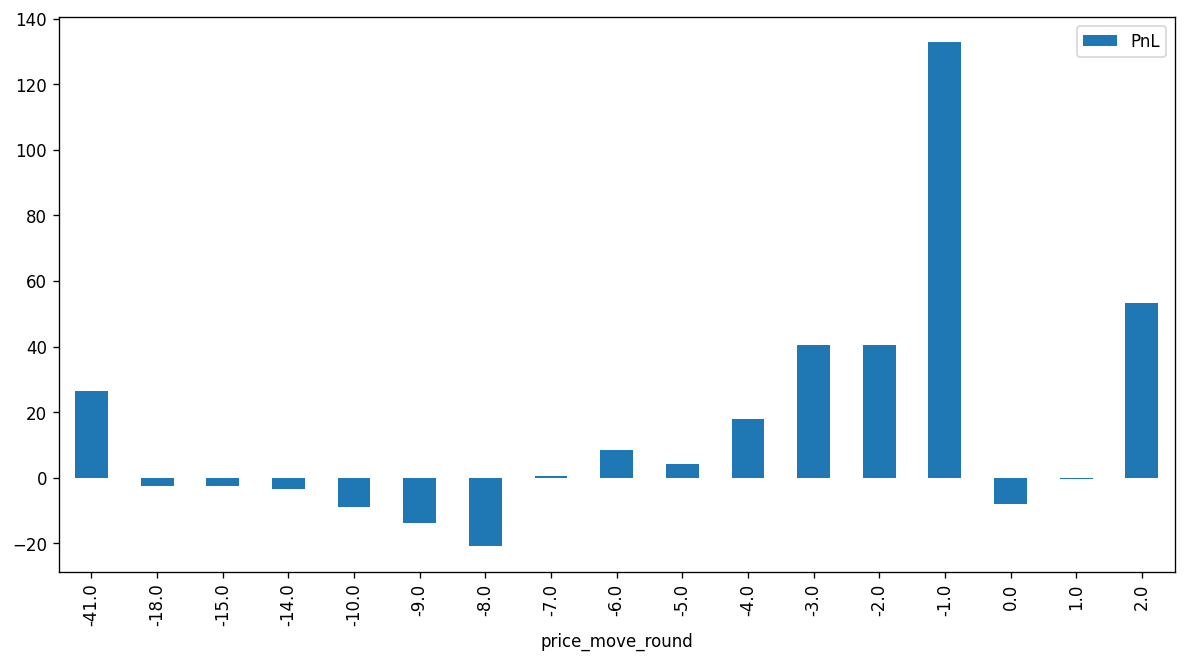

In [74]:
short_trades_grouped_by_pricemove_sum = short_trades.groupby(['price_move_round'])[['PnL']].sum()
short_trades_grouped_by_pricemove_sum.plot.bar()

## ADX analytics

<Axes: xlabel='ADX'>

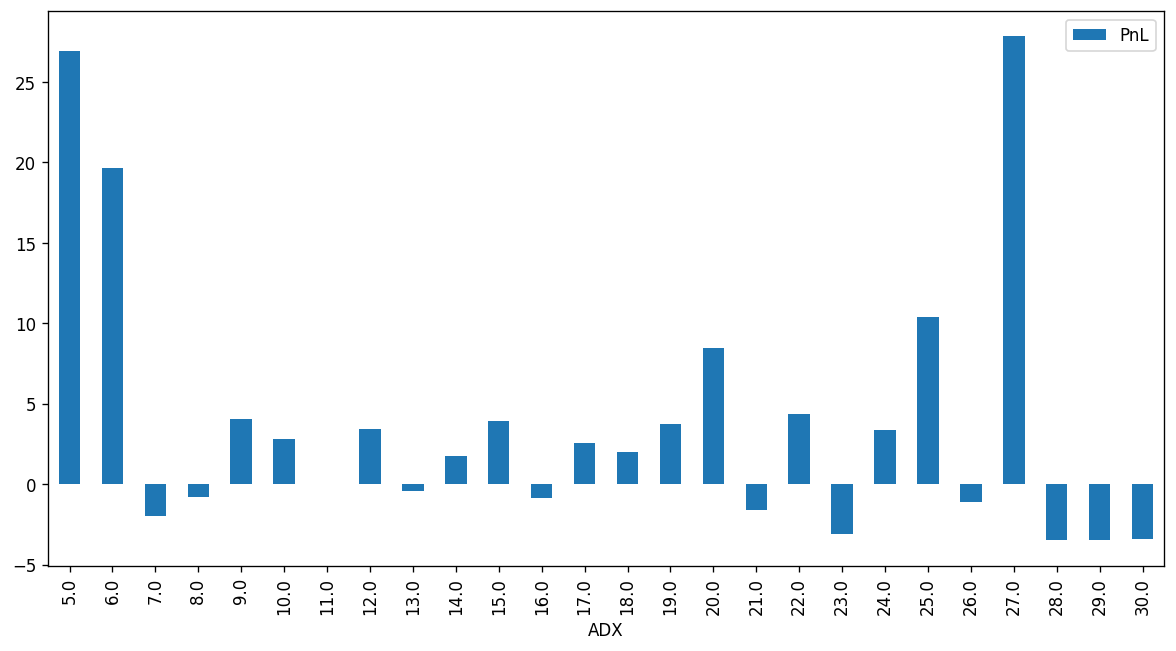

In [75]:
trades_grouped_by_adx = join_trades.groupby(['ADX'])[['PnL']].mean()
trades_grouped_by_adx.plot.bar()

<Axes: xlabel='ADX'>

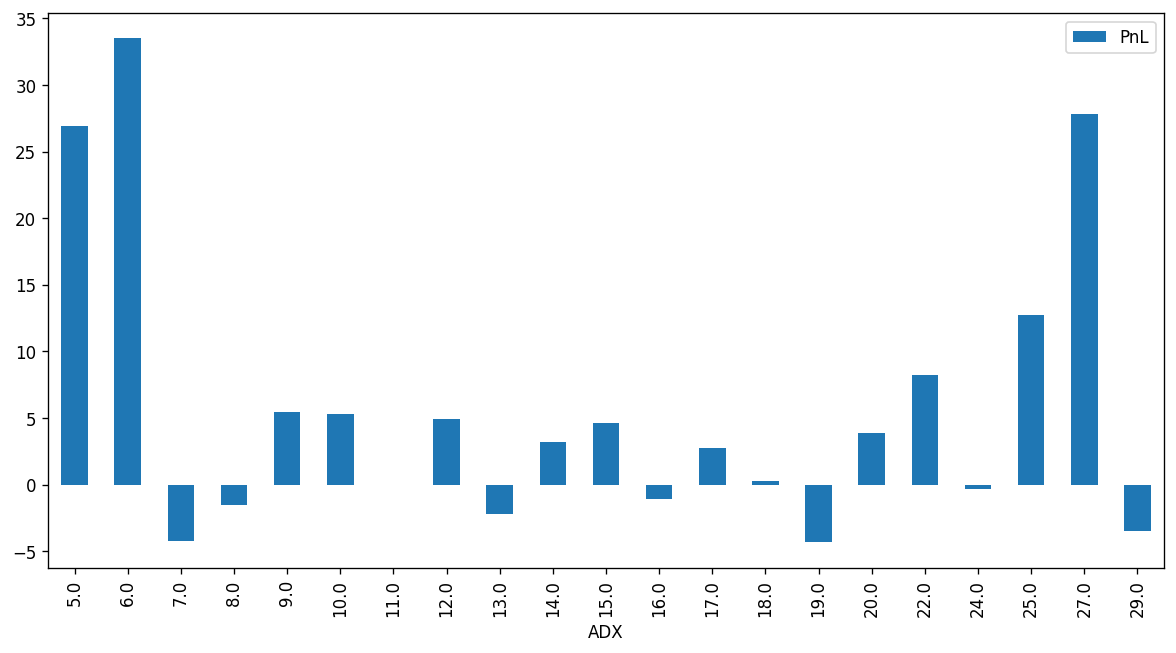

In [76]:
long_trades_grouped_by_adx = long_trades.groupby(['ADX'])[['PnL']].mean()
long_trades_grouped_by_adx.plot.bar()

<Axes: xlabel='ADX'>

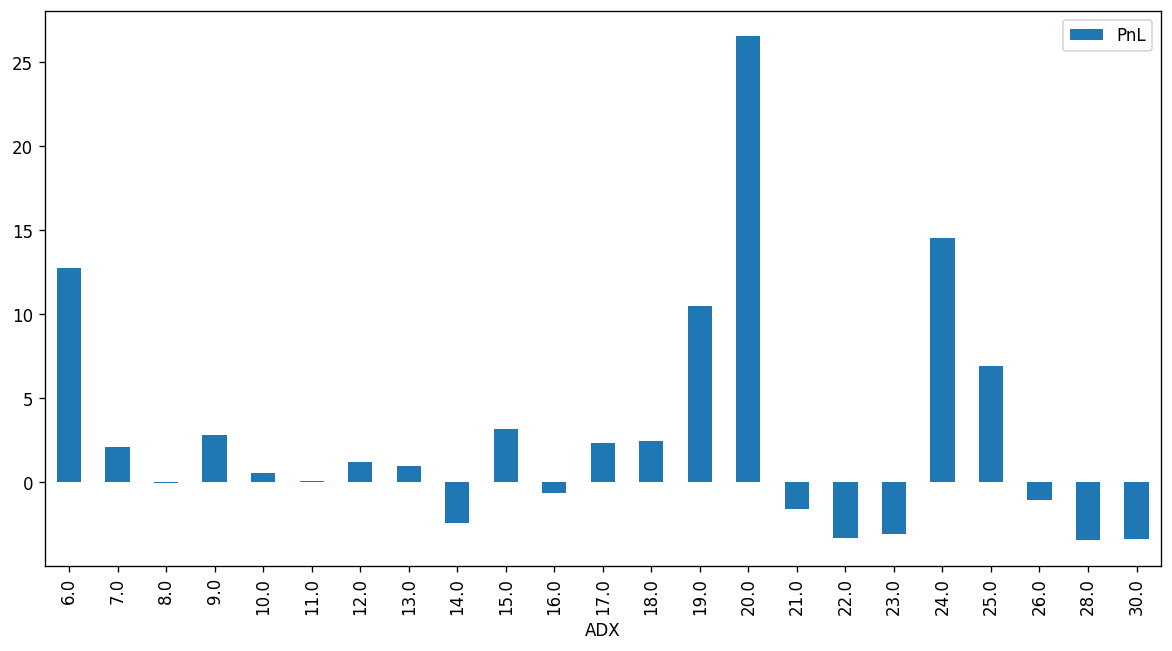

In [77]:
short_trades_grouped_by_adx = short_trades.groupby(['ADX'])[['PnL']].mean()
short_trades_grouped_by_adx.plot.bar()

<Axes: xlabel='ADX'>

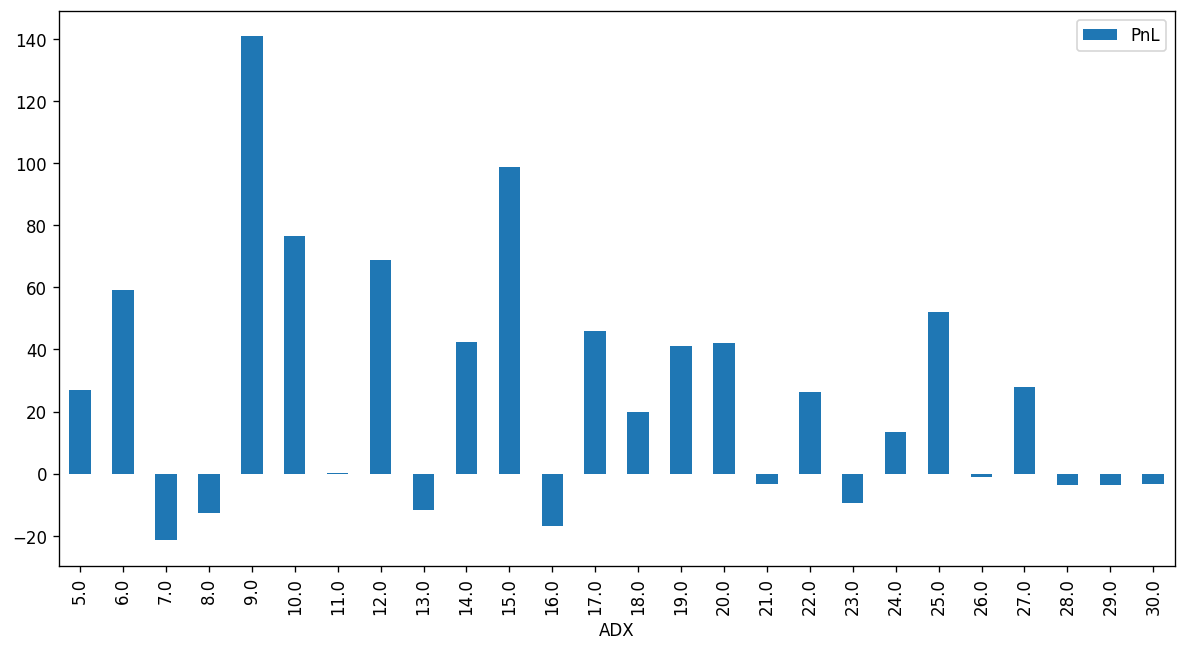

In [78]:
trades_grouped_by_adx_sum = join_trades.groupby(['ADX'])[['PnL']].sum()
trades_grouped_by_adx_sum.plot.bar()

<Axes: xlabel='ADX'>

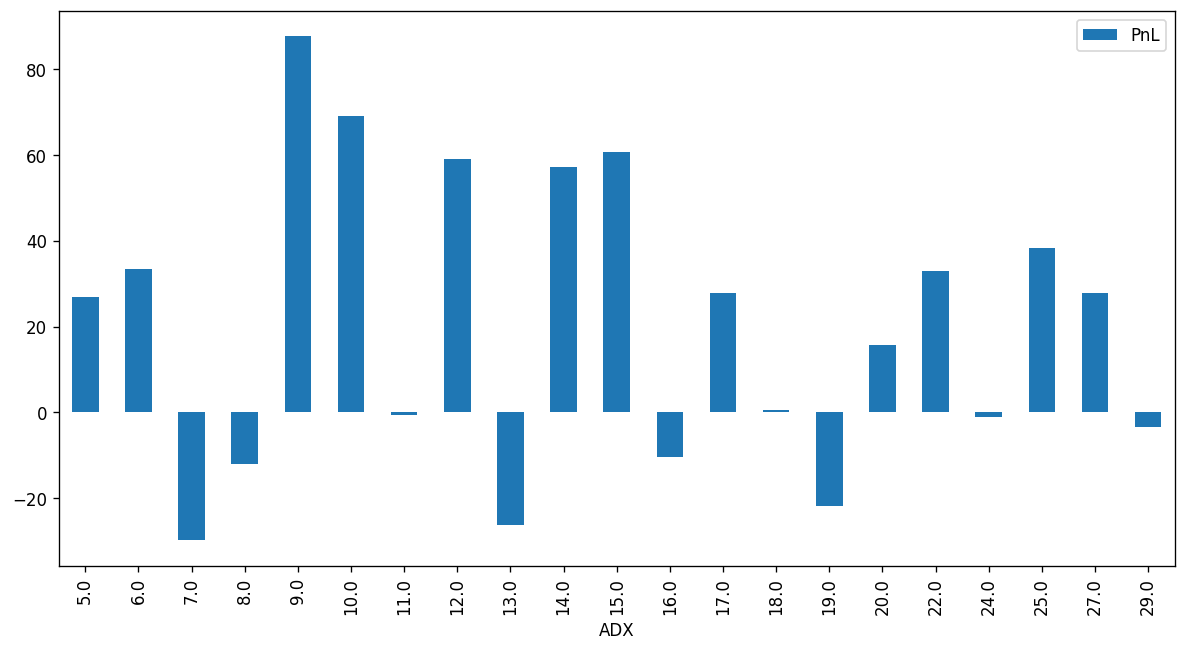

In [79]:
long_trades_grouped_by_adx_sum = long_trades.groupby(['ADX'])[['PnL']].sum()
long_trades_grouped_by_adx_sum.plot.bar()

<Axes: xlabel='ADX'>

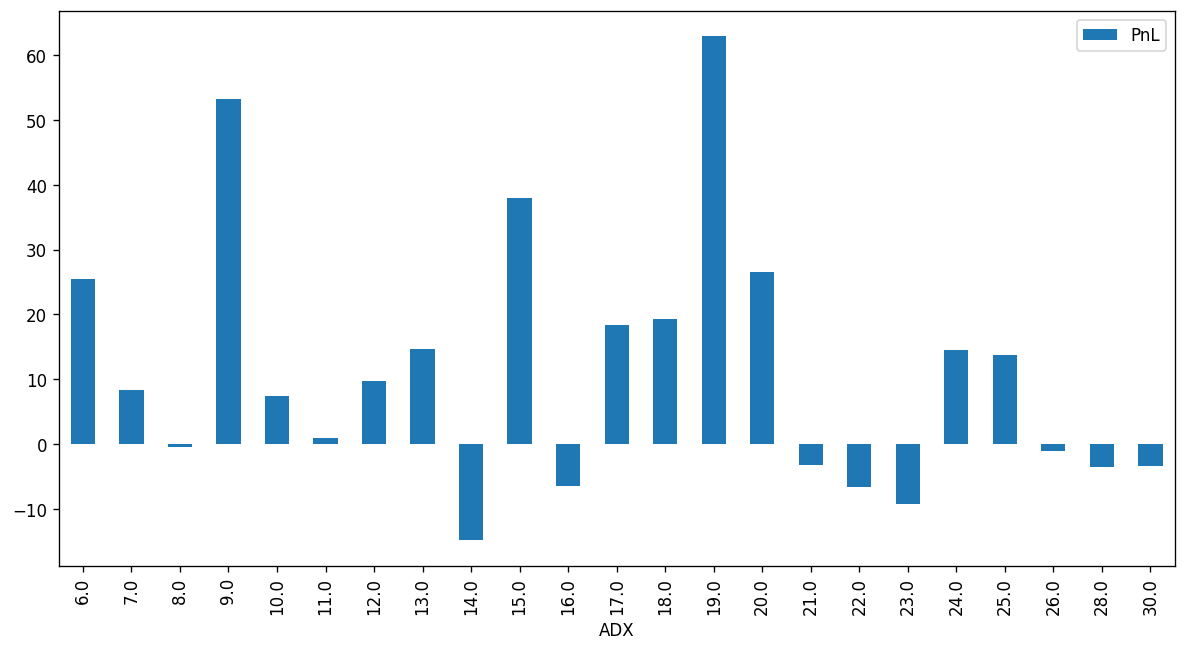

In [80]:
short_trades_grouped_by_adx_sum = short_trades.groupby(['ADX'])[['PnL']].sum()
short_trades_grouped_by_adx_sum.plot.bar()

<Axes: xlabel='ADX'>

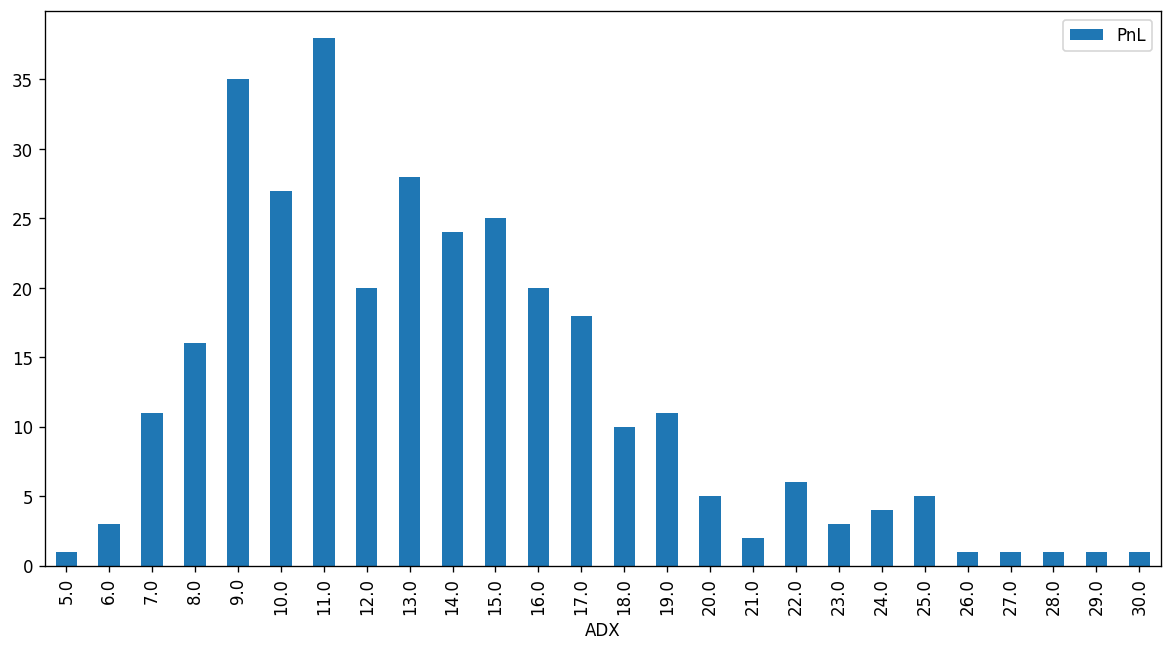

In [81]:
trades_grouped_by_adx_count = join_trades.groupby(['ADX'])[['PnL']].count()
trades_grouped_by_adx_count.plot.bar()

## RSI analytics by scatter  plot

Text(0, 0.5, 'PnL')

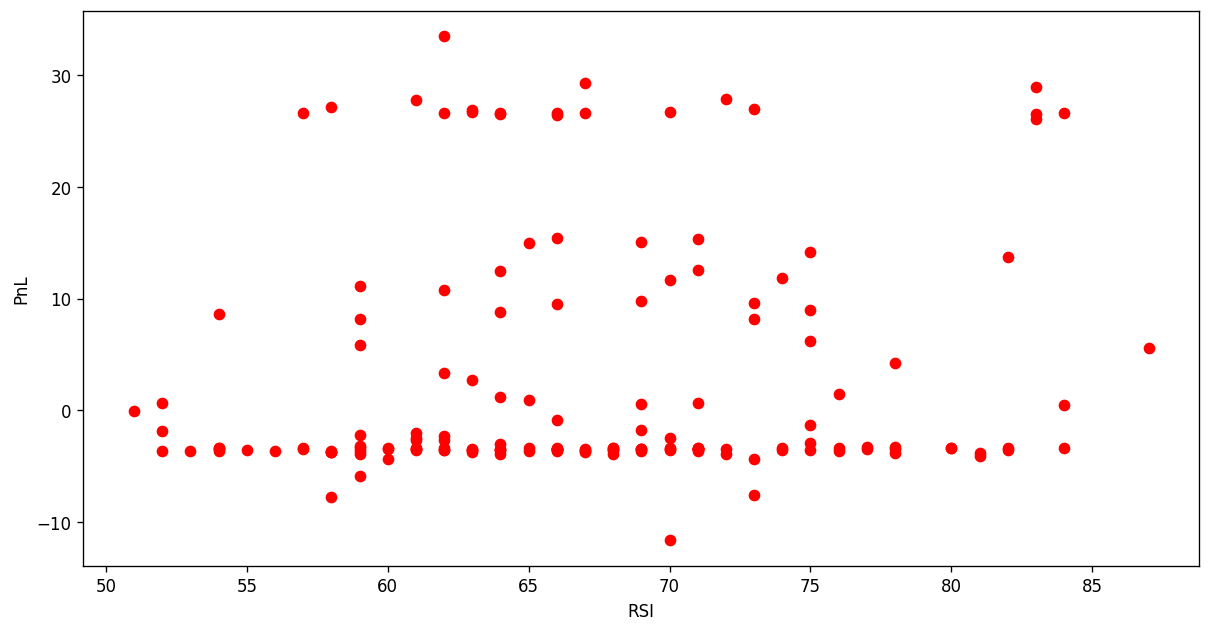

In [82]:
plt.scatter(long_trades['RSI'], long_trades['PnL'], color='red')
plt.xlabel("RSI")
plt.ylabel("PnL")

## analytics by IBS

Text(0, 0.5, 'PnL')

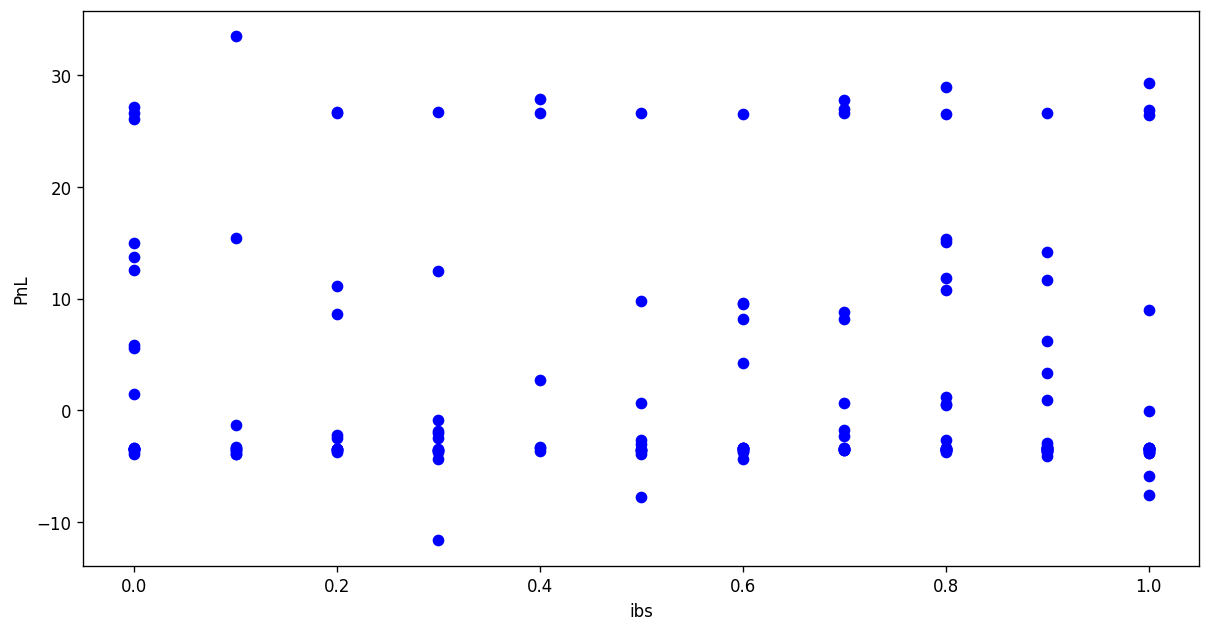

In [83]:
plt.scatter(long_trades['ibs'], long_trades['PnL'], color='blue')
plt.xlabel("ibs")
plt.ylabel("PnL")

## Different Volume analytics by scatter plot

Text(0, 0.5, 'PnL')

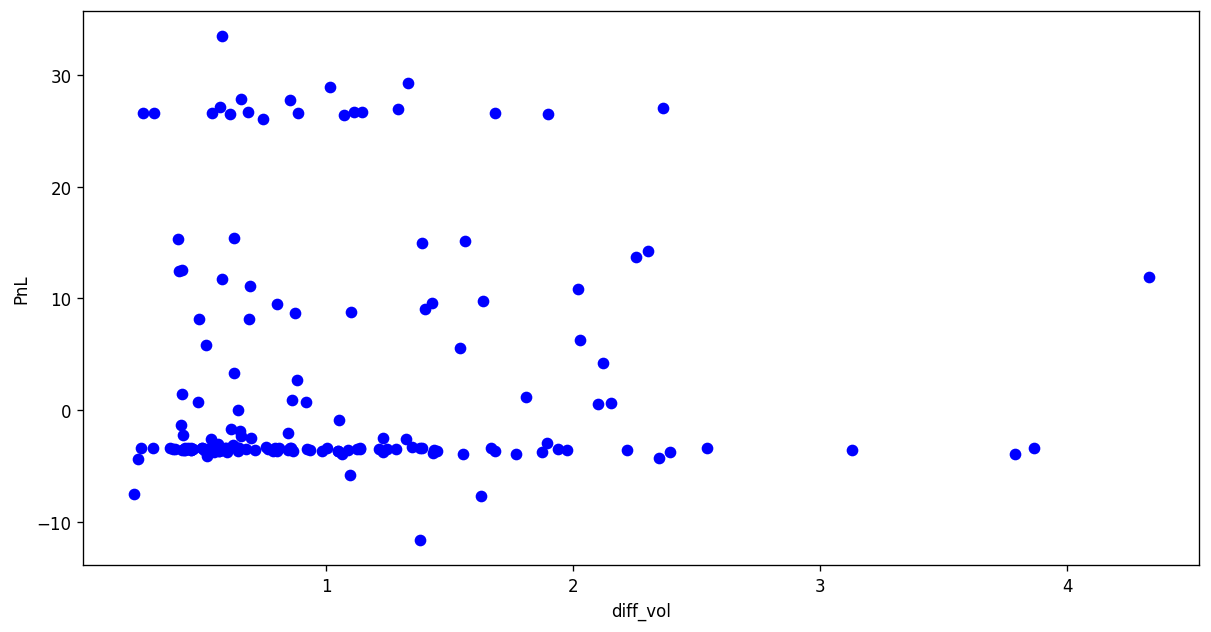

In [84]:
long_trades['diff_vol'] = long_trades['Volume'] / long_trades['vol_20_mean']
plt.scatter(long_trades['diff_vol'], long_trades['PnL'], color='blue')
plt.xlabel("diff_vol")
plt.ylabel("PnL")

<Axes: xlabel='diff_vol'>

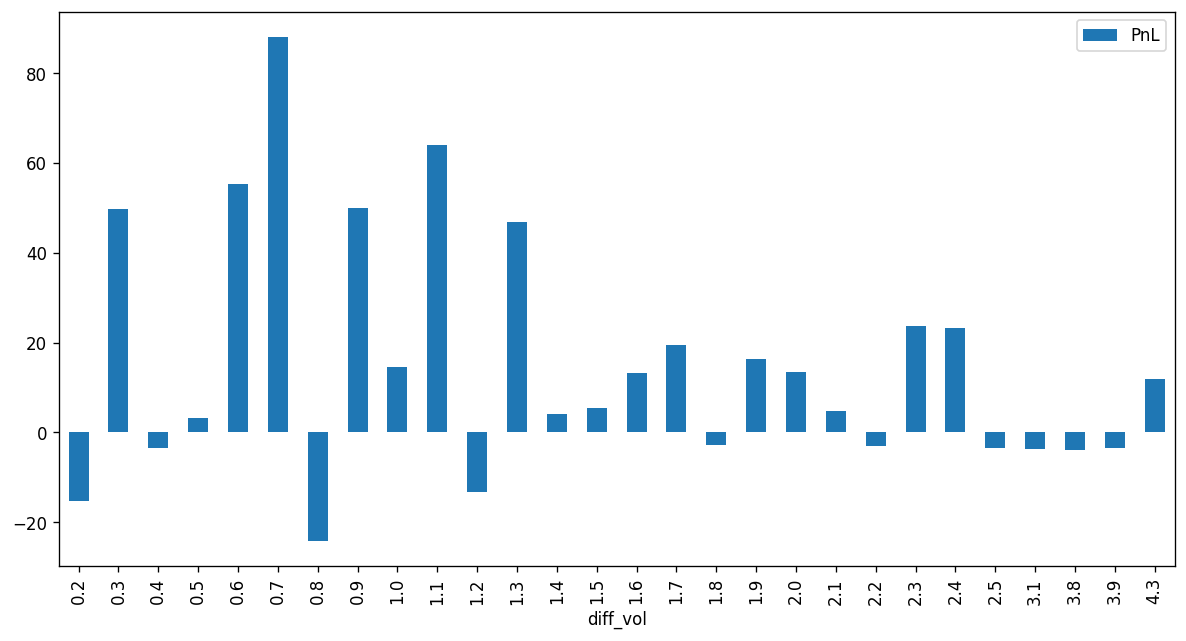

In [117]:
long_trades['diff_vol'] = round(long_trades['diff_vol'], 1)
ltrades_grouped_by_diffvol_sum = long_trades.groupby(['diff_vol'])[['PnL']].sum()
ltrades_grouped_by_diffvol_sum.plot.bar()

## Different price 10 bars analytics by scatter plot

Text(0, 0.5, 'PnL')

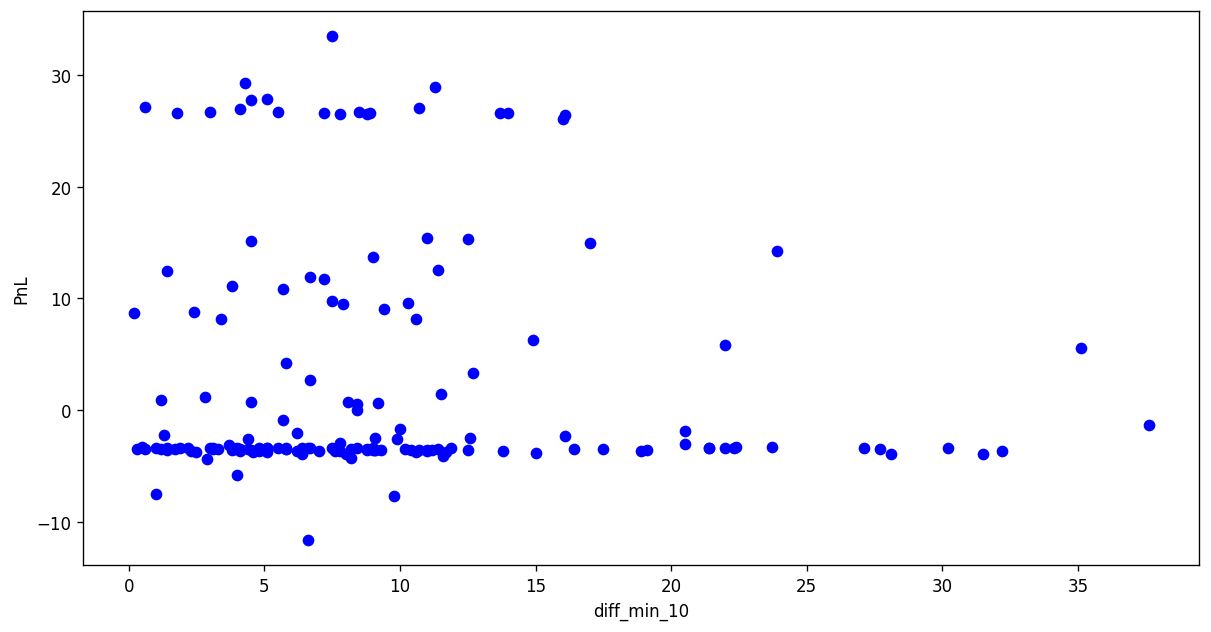

In [86]:
long_trades['diff_min_10'] = long_trades['Close'] - long_trades['min_in_range']
plt.scatter(long_trades['diff_min_10'], long_trades['PnL'], color='blue')
plt.xlabel("diff_min_10")
plt.ylabel("PnL")

## Different EMA fast & low analytics by scatter plot

Text(0, 0.5, 'PnL')

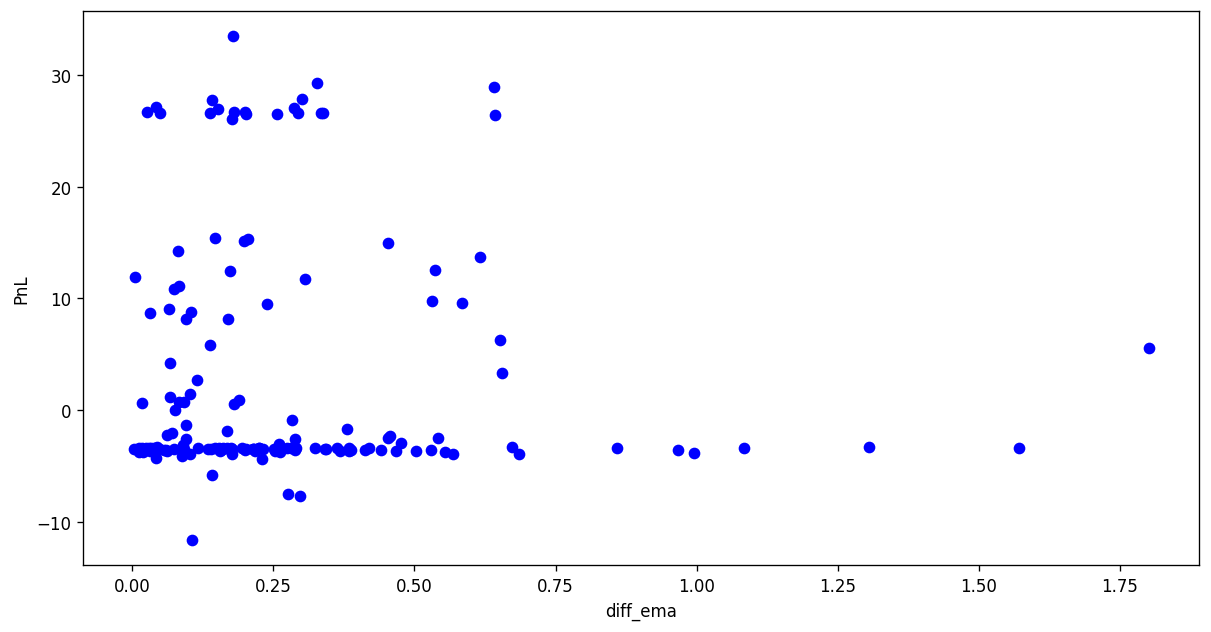

In [87]:
long_trades['diff_ema'] = long_trades['ema_fast'] - long_trades['ema_low']
plt.scatter(long_trades['diff_ema'], long_trades['PnL'], color='blue')
plt.xlabel("diff_ema")
plt.ylabel("PnL")

## Different price & EMA low analytics by scatter plot

Text(0, 0.5, 'PnL')

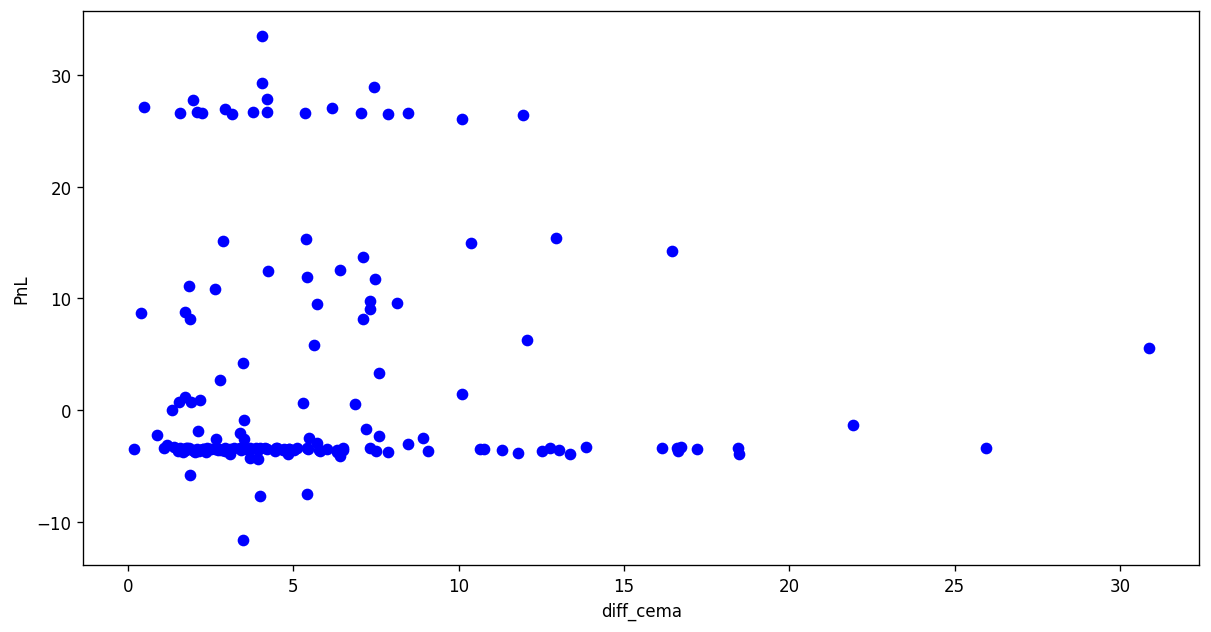

In [88]:
long_trades['diff_cema'] = long_trades['Close'] - long_trades['ema_low']
plt.scatter(long_trades['diff_cema'], long_trades['PnL'], color='blue')
plt.xlabel("diff_cema")
plt.ylabel("PnL")

<Axes: xlabel='diff_cema'>

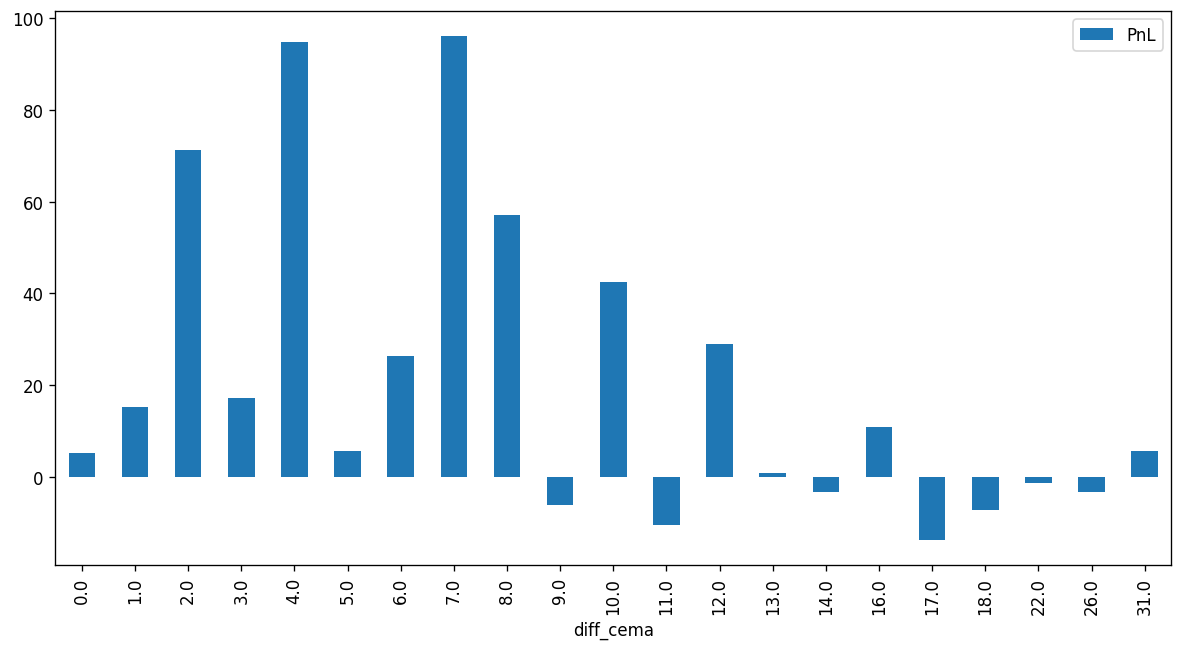

In [89]:
long_trades['diff_cema'] = round(long_trades['diff_cema'])
long_trades_grouped_by_diff_cema = long_trades.groupby(['diff_cema'])[['PnL']].sum()
long_trades_grouped_by_diff_cema.plot.bar()

In [90]:
long_trades[long_trades.diff_cema > 12.5]['PnL'].sum()

-12.06736999999896

Text(0, 0.5, 'PnL')

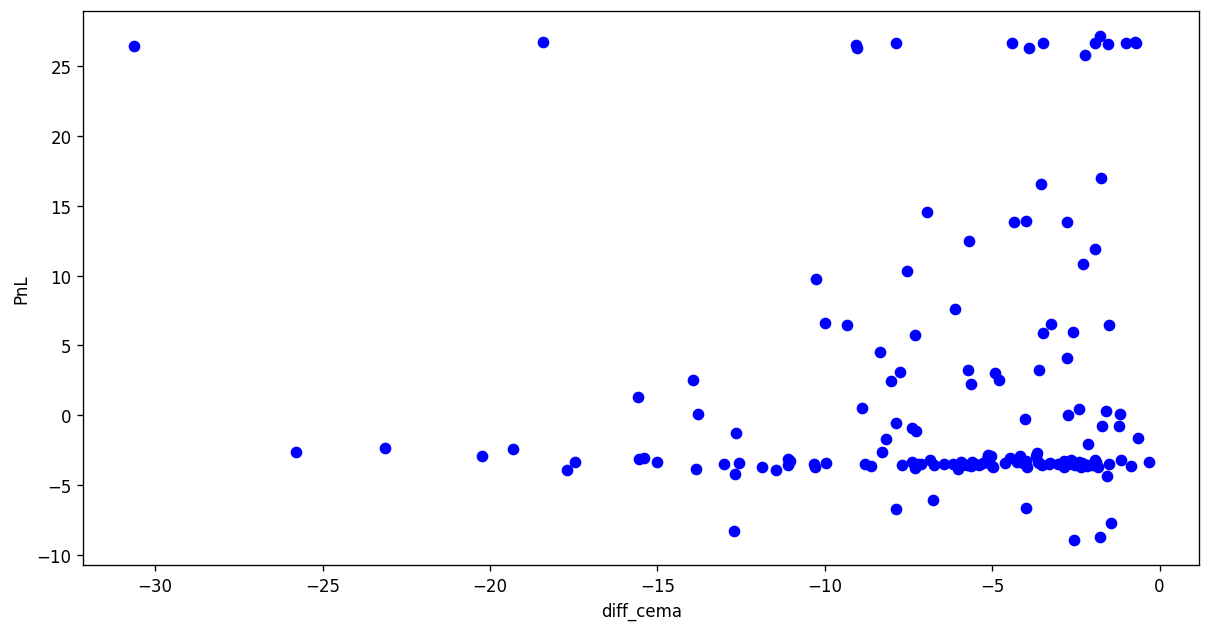

In [91]:
short_trades['diff_cema'] = short_trades['Close'] - short_trades['ema_low']
plt.scatter(short_trades['diff_cema'], short_trades['PnL'], color='blue')
plt.xlabel("diff_cema")
plt.ylabel("PnL")

<Axes: xlabel='diff_cema'>

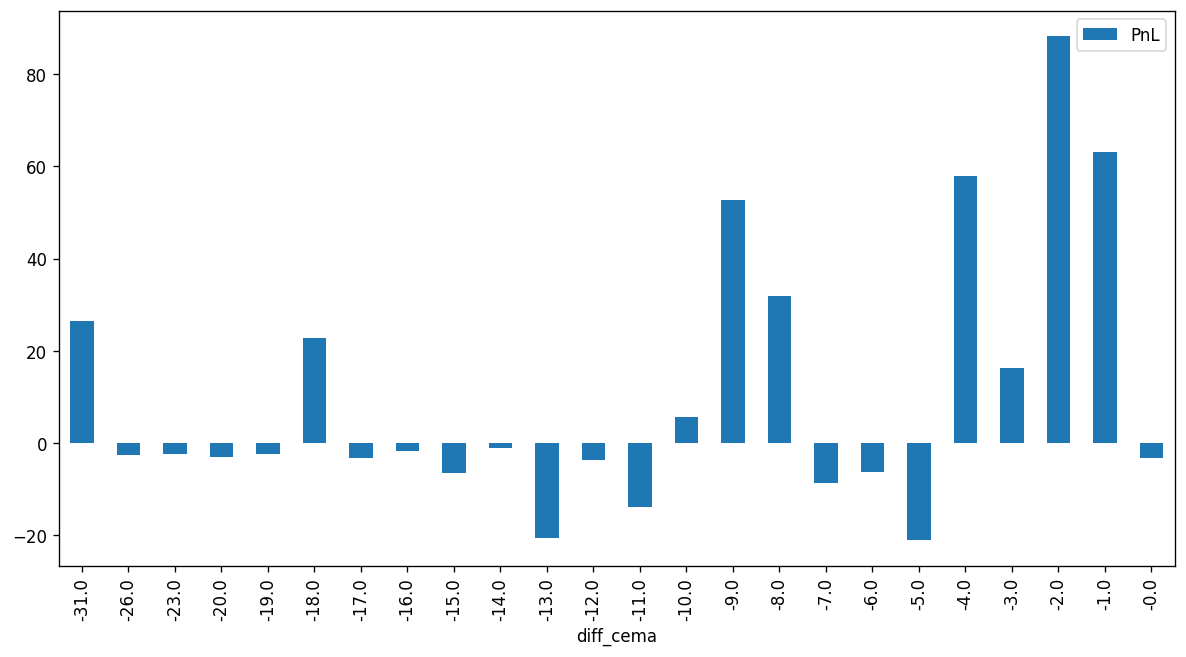

In [92]:
short_trades['diff_cema'] = round(short_trades['diff_cema'])
short_trades_grouped_by_diff_cema = short_trades.groupby(['diff_cema'])[['PnL']].sum()
short_trades_grouped_by_diff_cema.plot.bar()

In [93]:
short_trades[short_trades.diff_cema < -9.5]['PnL'].sum()

-6.554709999997613

Text(0, 0.5, 'PnL')

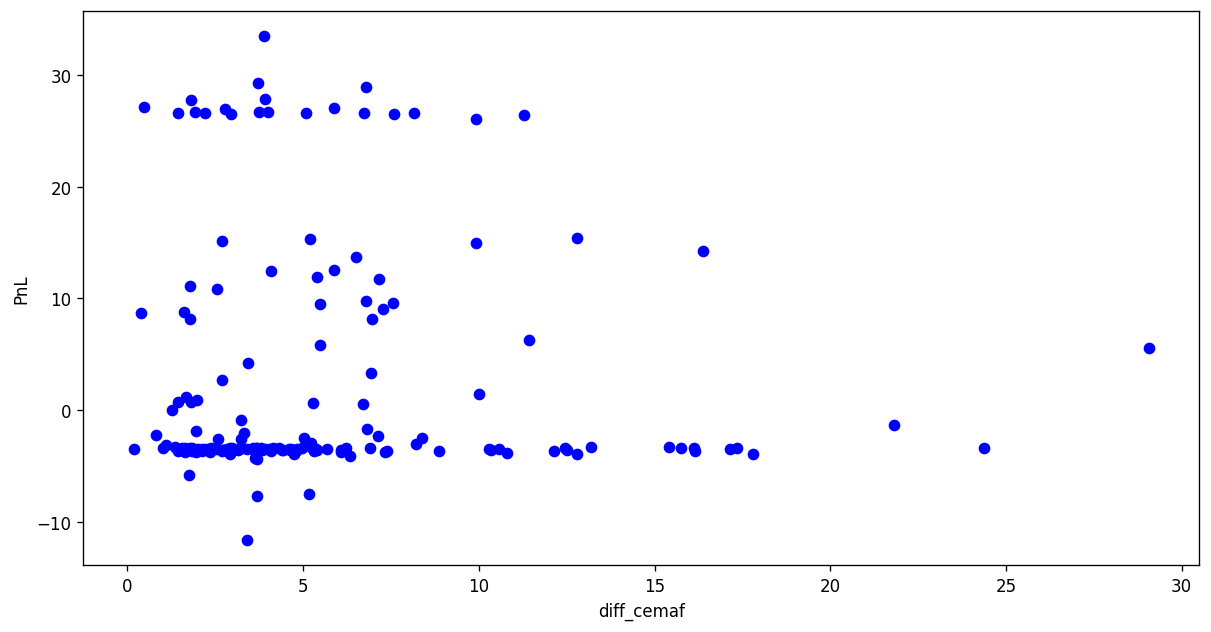

In [94]:
long_trades['diff_cemaf'] = long_trades['Close'] - long_trades['ema_fast']
plt.scatter(long_trades['diff_cemaf'], long_trades['PnL'], color='blue')
plt.xlabel("diff_cemaf")
plt.ylabel("PnL")

## Candlestick's body analytics by scatter plot

Text(0, 0.5, 'PnL')

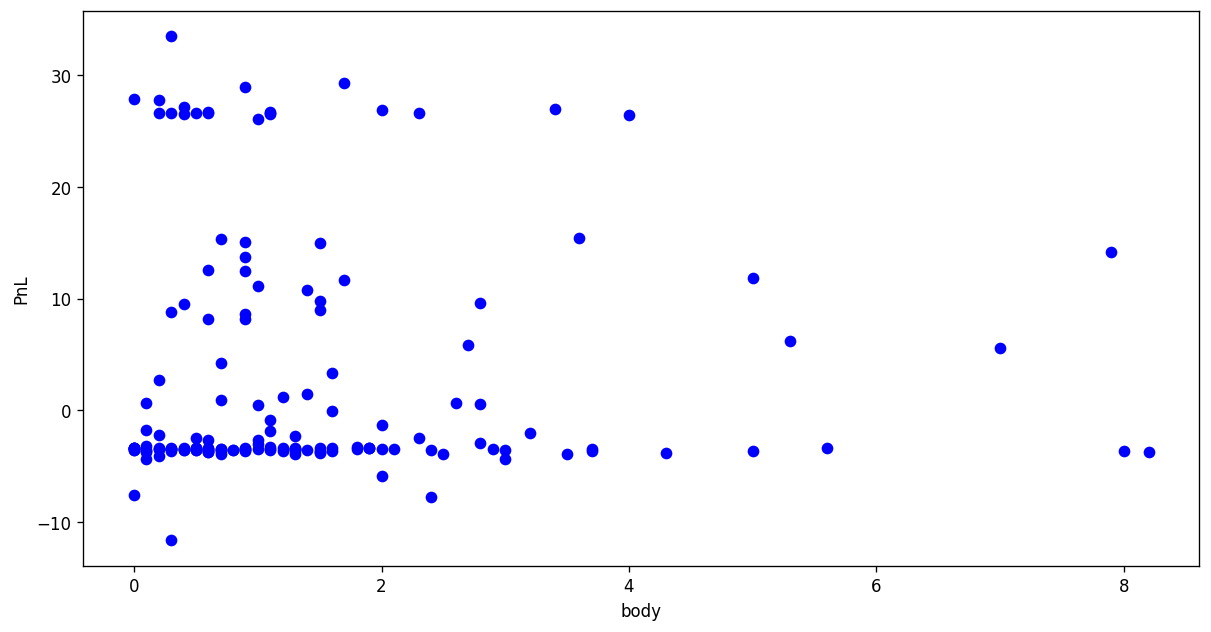

In [95]:
plt.scatter(long_trades['body'], long_trades['PnL'], color='blue')
plt.xlabel("body")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

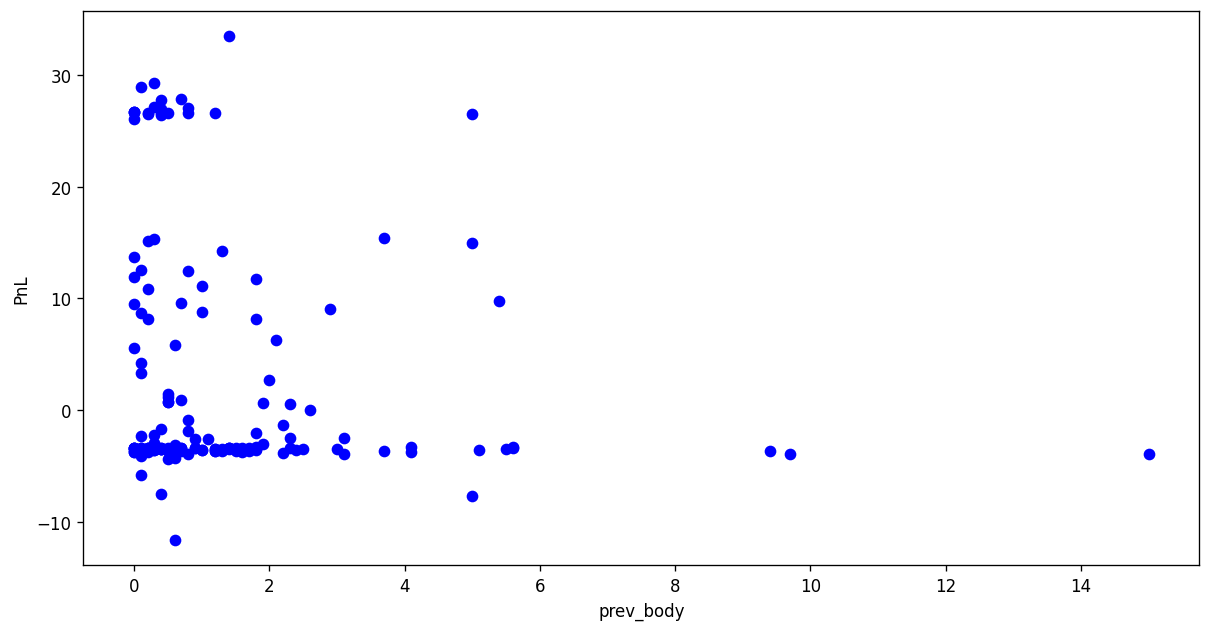

In [96]:
plt.scatter(long_trades['prev_body'], long_trades['PnL'], color='blue')
plt.xlabel("prev_body")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

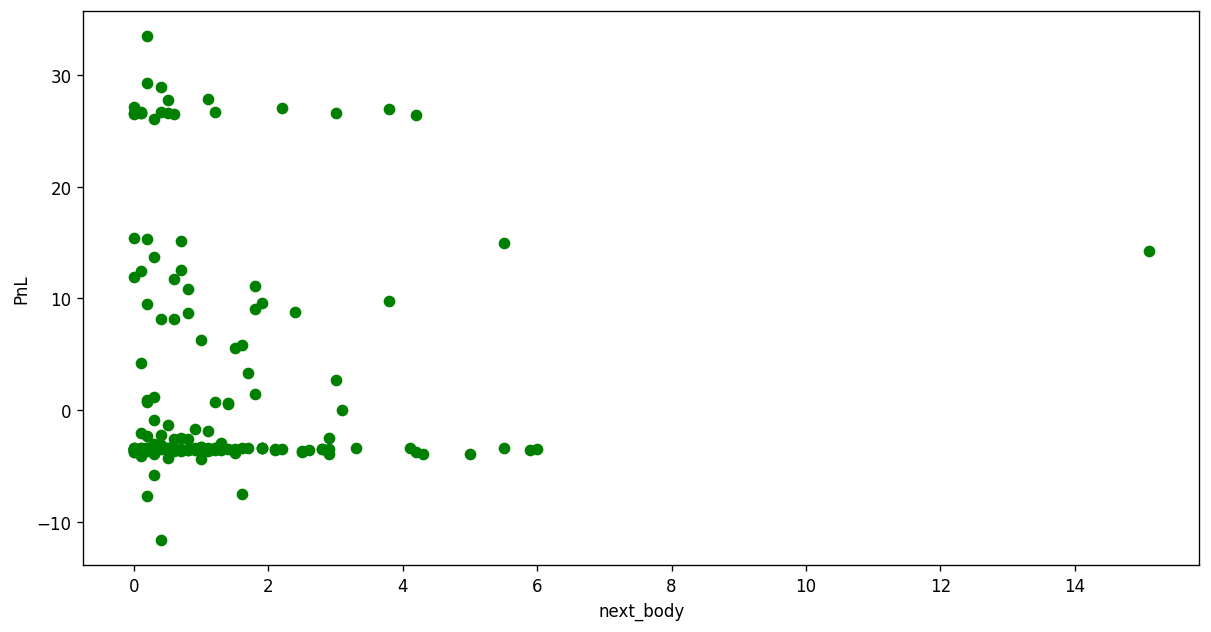

In [97]:
plt.scatter(long_trades['next_body'], long_trades['PnL'], color='green')
plt.xlabel("next_body")
plt.ylabel("PnL")

## Day of Week analytics

<Axes: xlabel='day_of_week'>

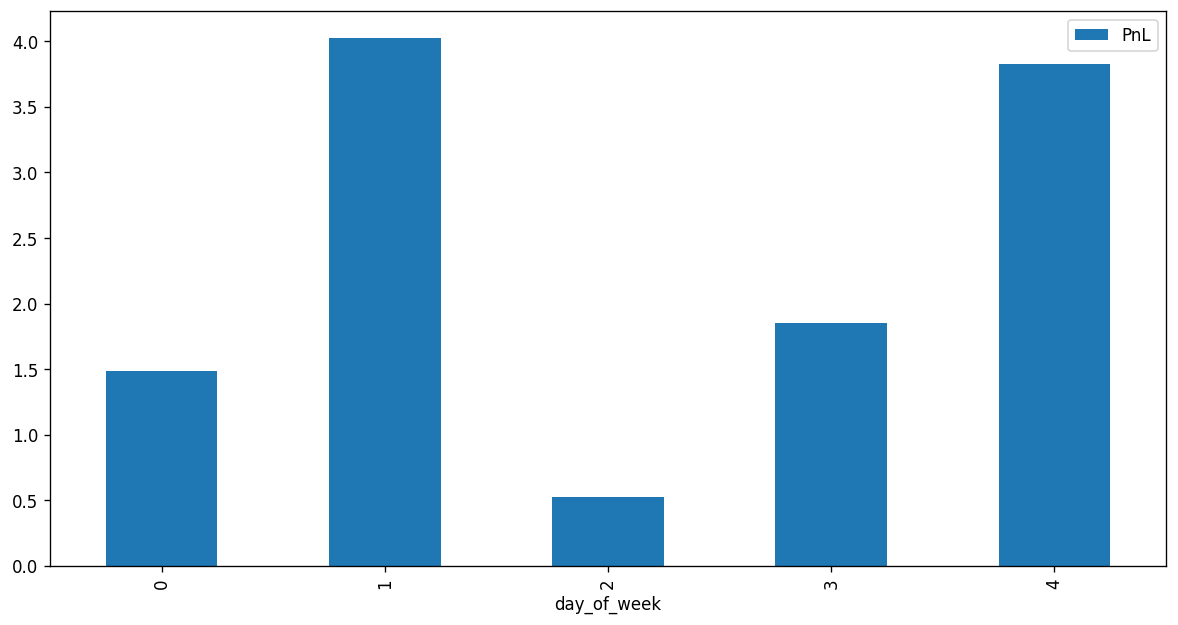

In [98]:
join_trades['day_of_week'] = join_trades['EntryTime'].dt.dayofweek
trades_grouped_by_dow = join_trades.groupby(['day_of_week'])[['PnL']].mean()
trades_grouped_by_dow.plot.bar()

<Axes: xlabel='day_of_week'>

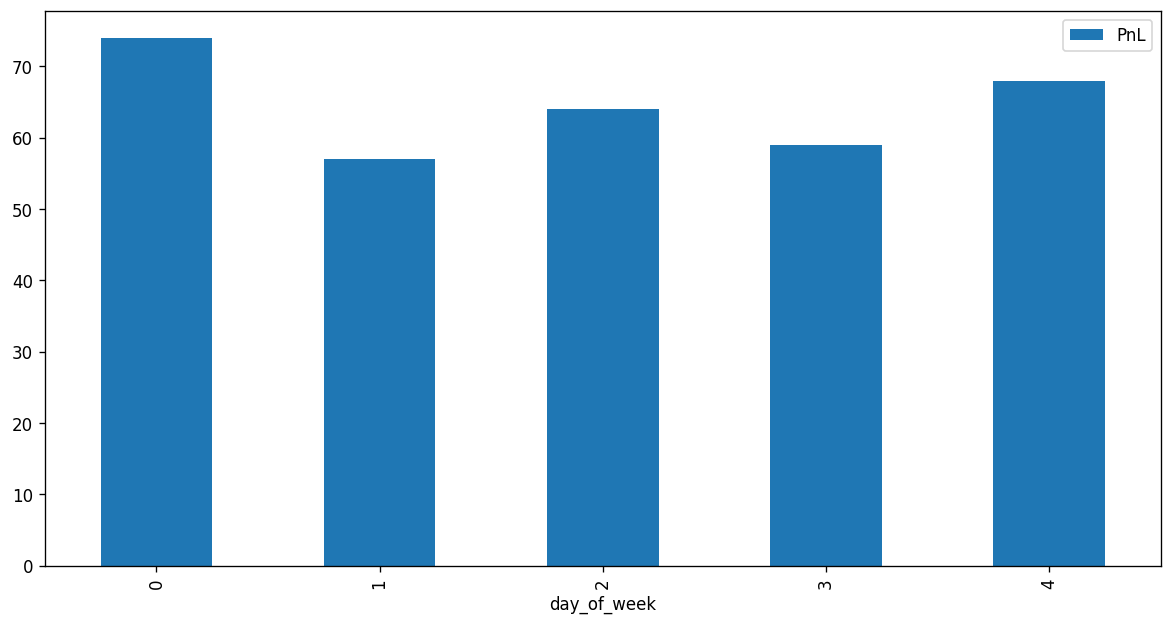

In [99]:
trades_grouped2_by_dow = join_trades.groupby(['day_of_week'])[['PnL']].count()
trades_grouped2_by_dow.plot.bar()

## Day of Month analytics

<Axes: xlabel='day_of_month'>

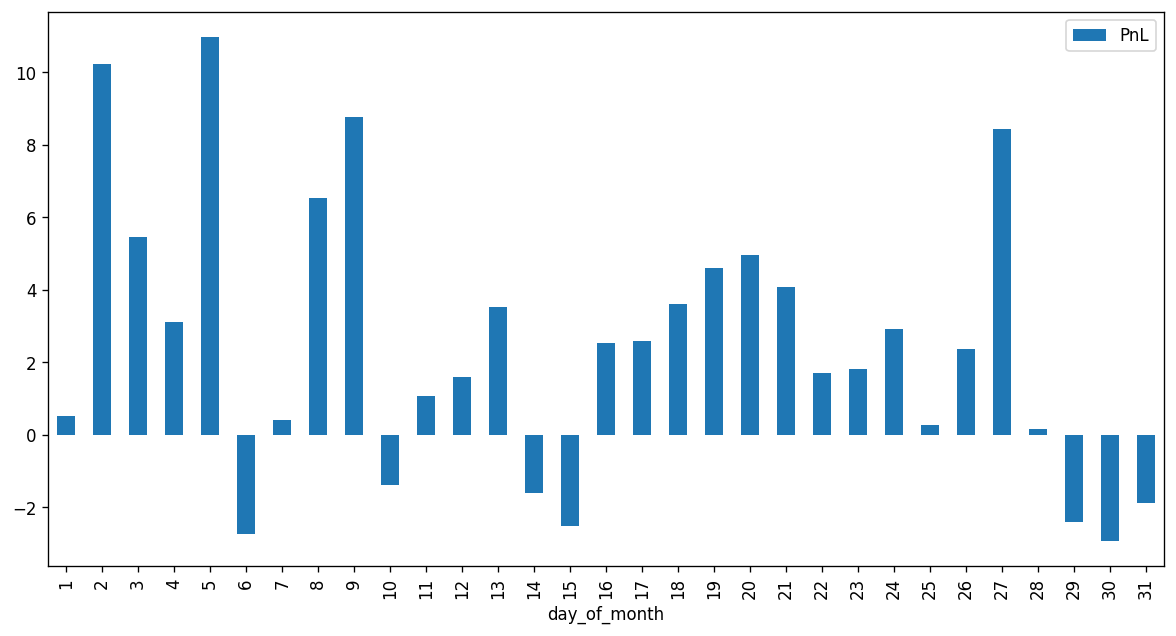

In [100]:
join_trades['day_of_month'] = join_trades['EntryTime'].dt.day
trades_grouped_by_dom = join_trades.groupby(['day_of_month'])[['PnL']].mean()
trades_grouped_by_dom.plot.bar()

<Axes: xlabel='day_of_month'>

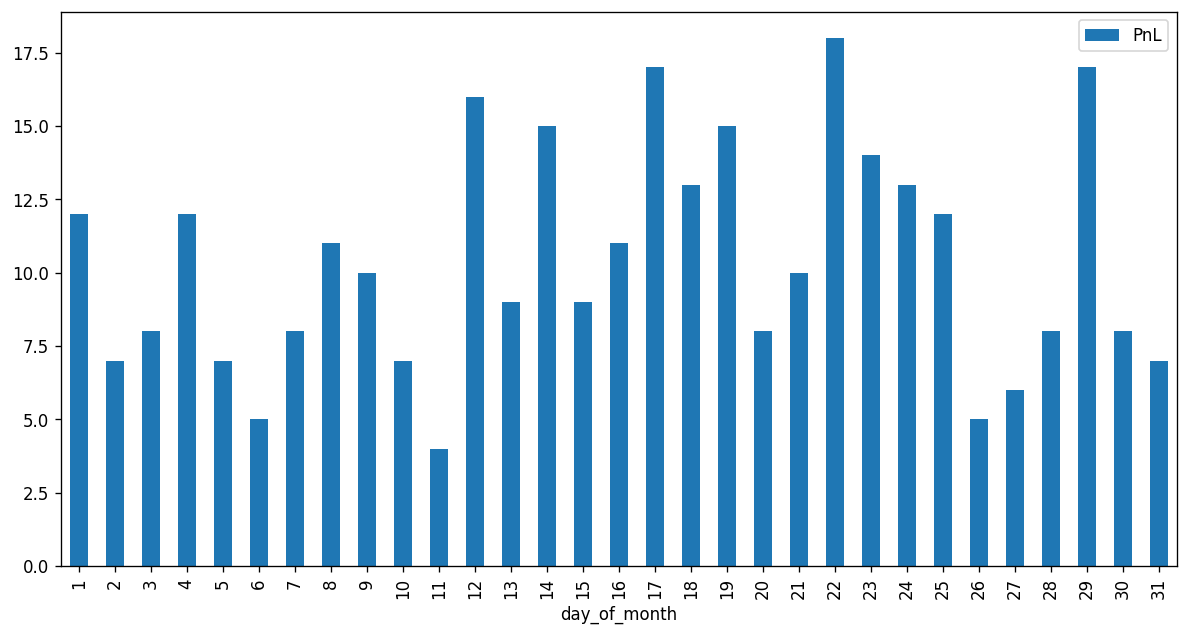

In [101]:
trades_grouped2_by_dom = join_trades.groupby(['day_of_month'])[['PnL']].count()
trades_grouped2_by_dom.plot.bar()

## Trade by Month analytics

<Axes: xlabel='month'>

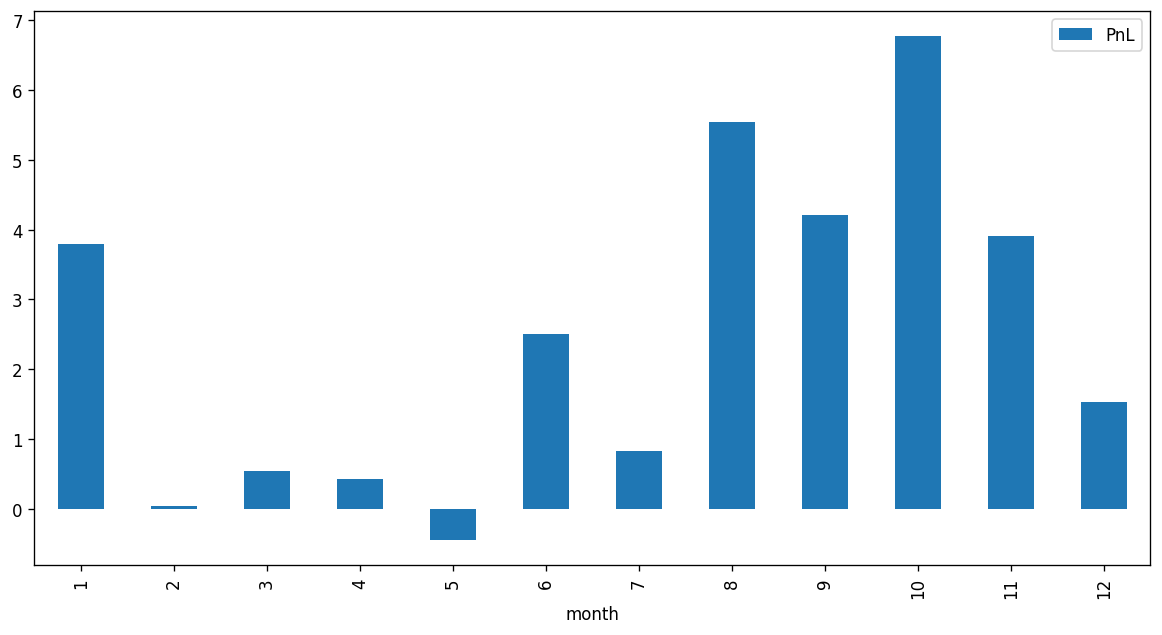

In [102]:
join_trades['month'] = join_trades['EntryTime'].dt.month
trades_grouped_by_month = join_trades.groupby(['month'])[['PnL']].mean()
trades_grouped_by_month.plot.bar()

<Axes: xlabel='month'>

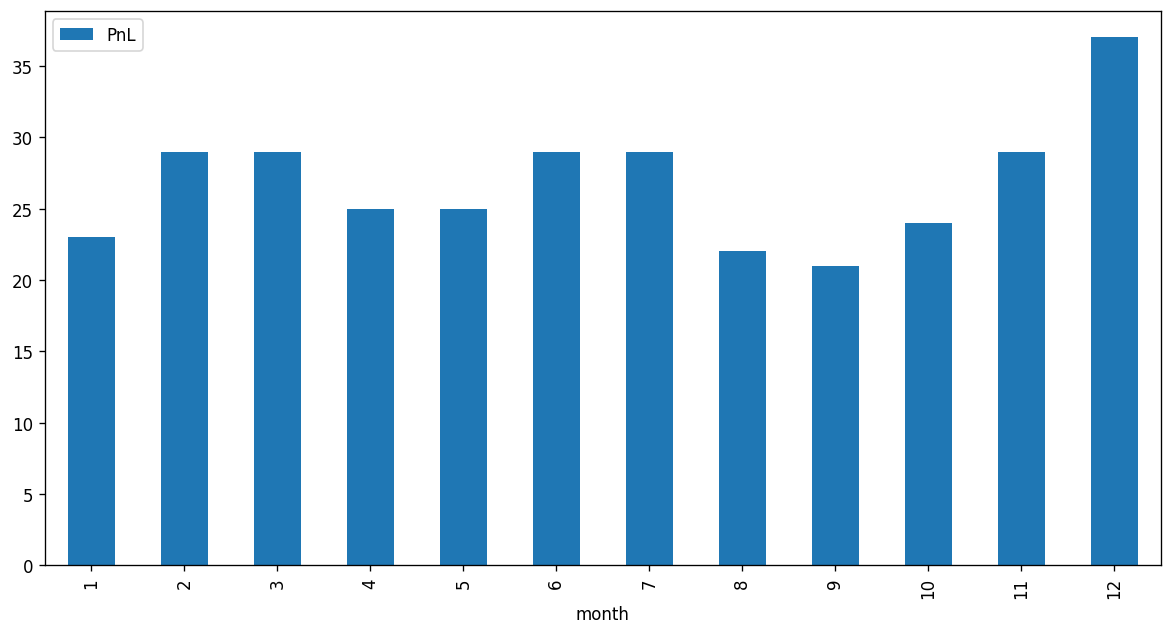

In [103]:
trades_grouped_by_monthc = join_trades.groupby(['month'])[['PnL']].count()
trades_grouped_by_monthc.plot.bar()

<Axes: xlabel='month'>

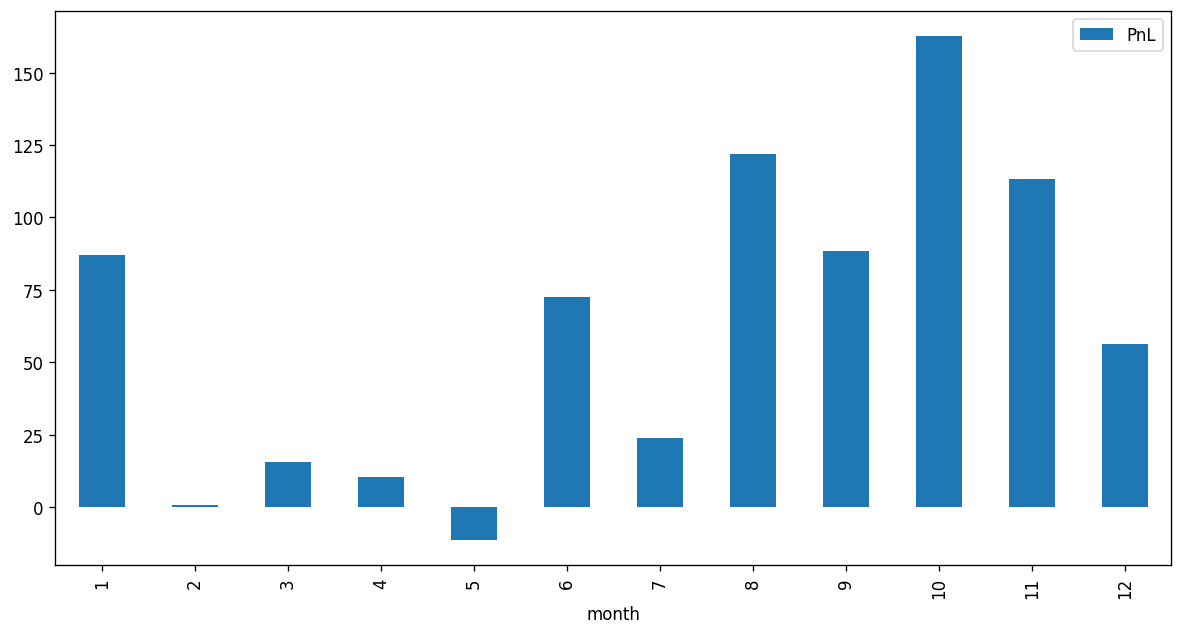

In [104]:
trades_grouped_by_months = join_trades.groupby(['month'])[['PnL']].sum()
trades_grouped_by_months.plot.bar()

<Axes: xlabel='month'>

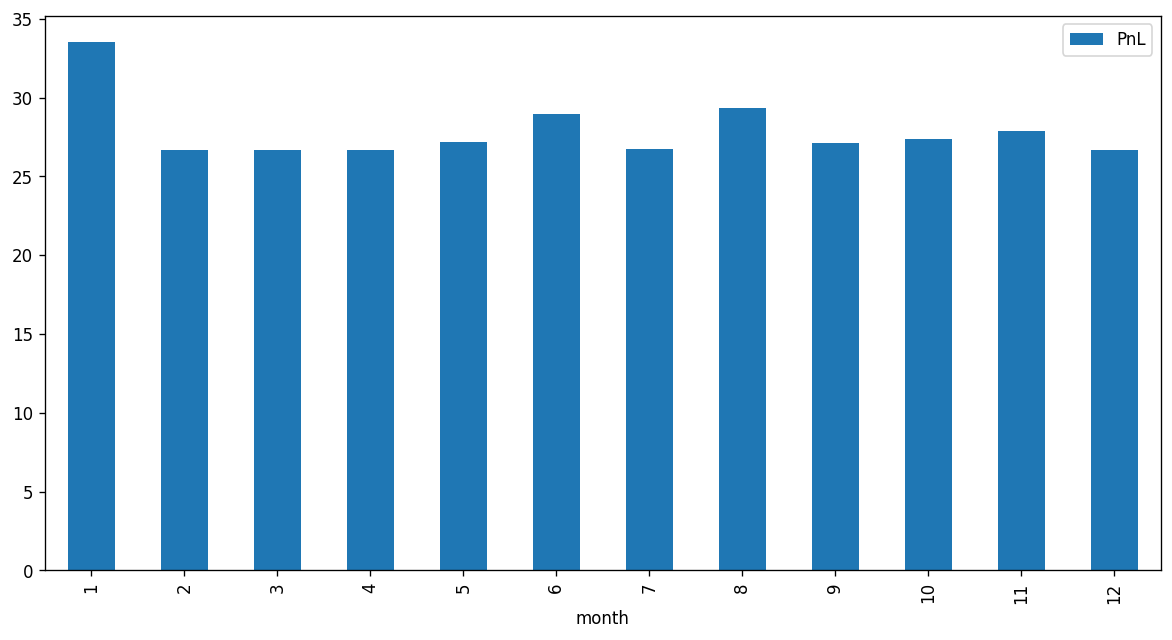

In [105]:
trades_grouped_by_monthma = join_trades.groupby(['month'])[['PnL']].max()
trades_grouped_by_monthma.plot.bar()

<Axes: xlabel='month'>

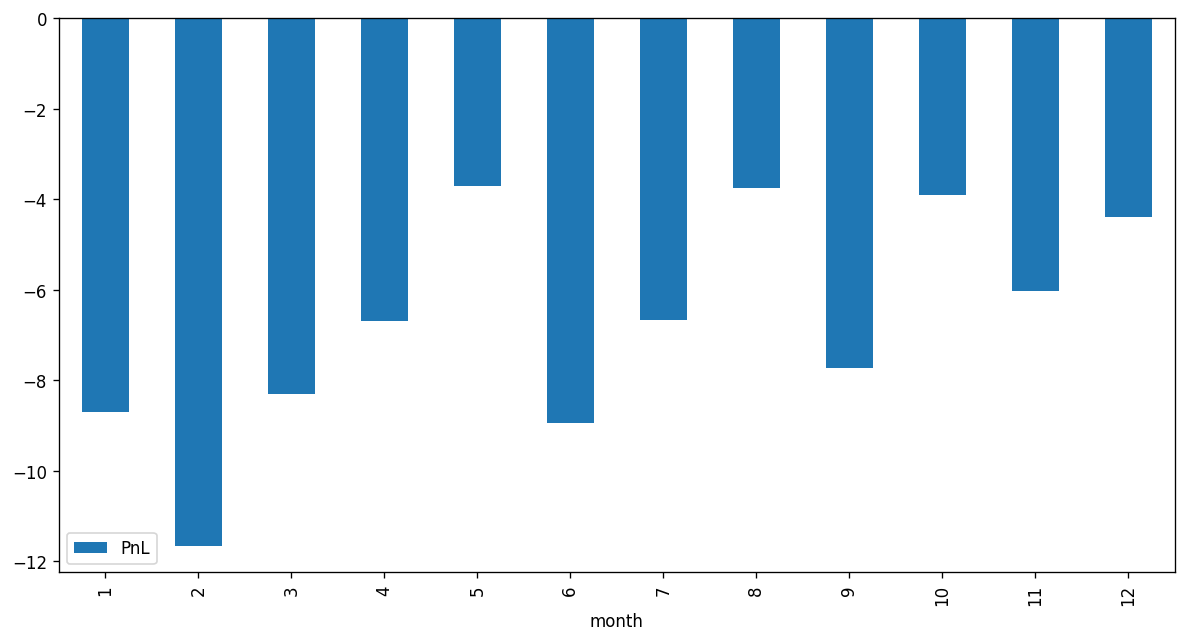

In [106]:
trades_grouped_by_monthmi = join_trades.groupby(['month'])[['PnL']].min()
trades_grouped_by_monthmi.plot.bar()

<Axes: xlabel='year_month'>

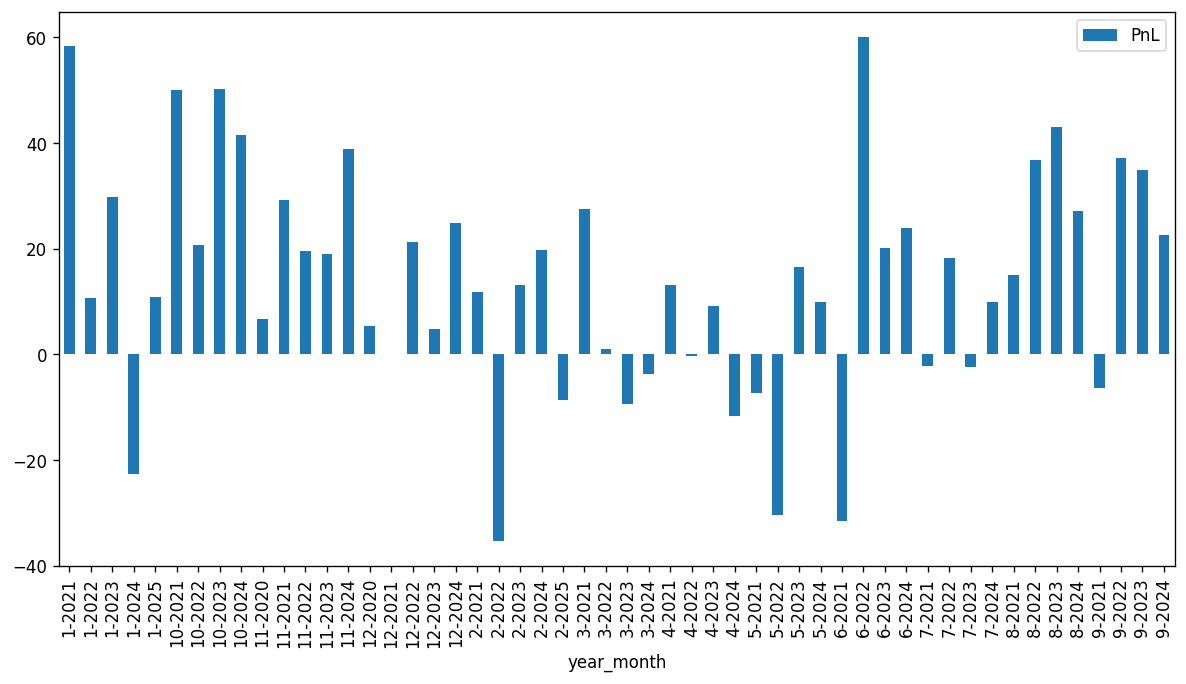

In [107]:
join_trades['year_month'] = join_trades.apply(lambda r: str(r['EntryTime'].month) + '-' + str(r['EntryTime'].year), axis=1)
trades_grouped_by_ymonths = join_trades.groupby(['year_month'])[['PnL']].sum()
trades_grouped_by_ymonths.plot.bar()

## Trade by Year analytics

<Axes: xlabel='year'>

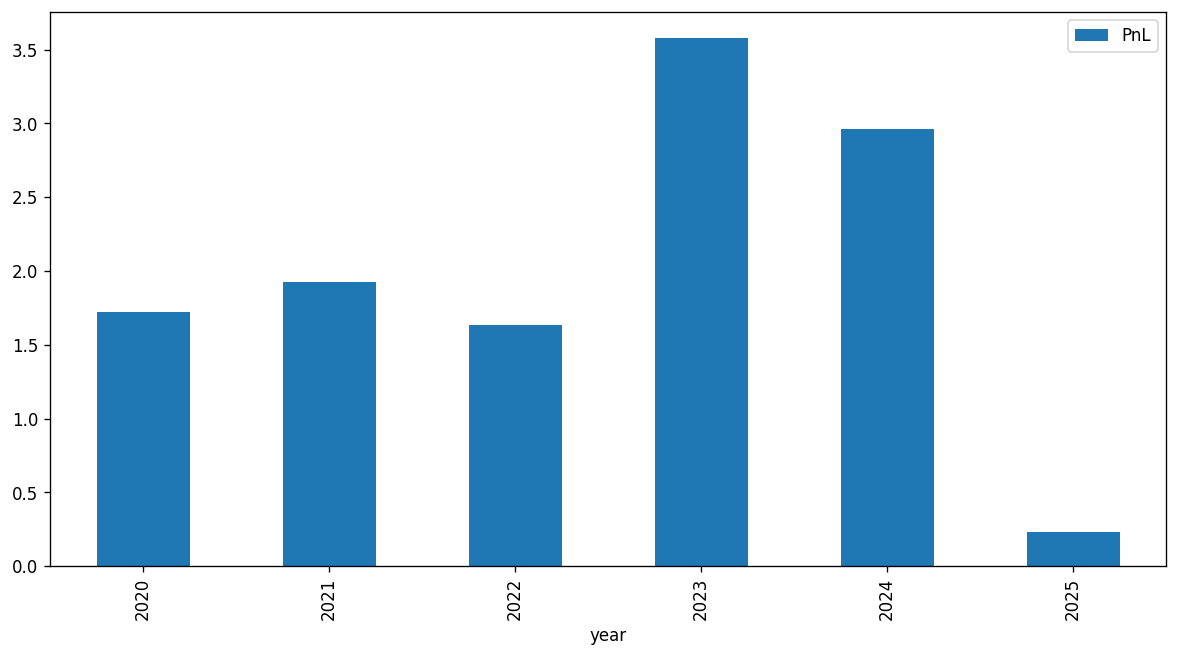

In [108]:
join_trades['year'] = join_trades['EntryTime'].dt.year
trades_grouped_by_year = join_trades.groupby(['year'])[['PnL']].mean()
trades_grouped_by_year.plot.bar()

<Axes: xlabel='year'>

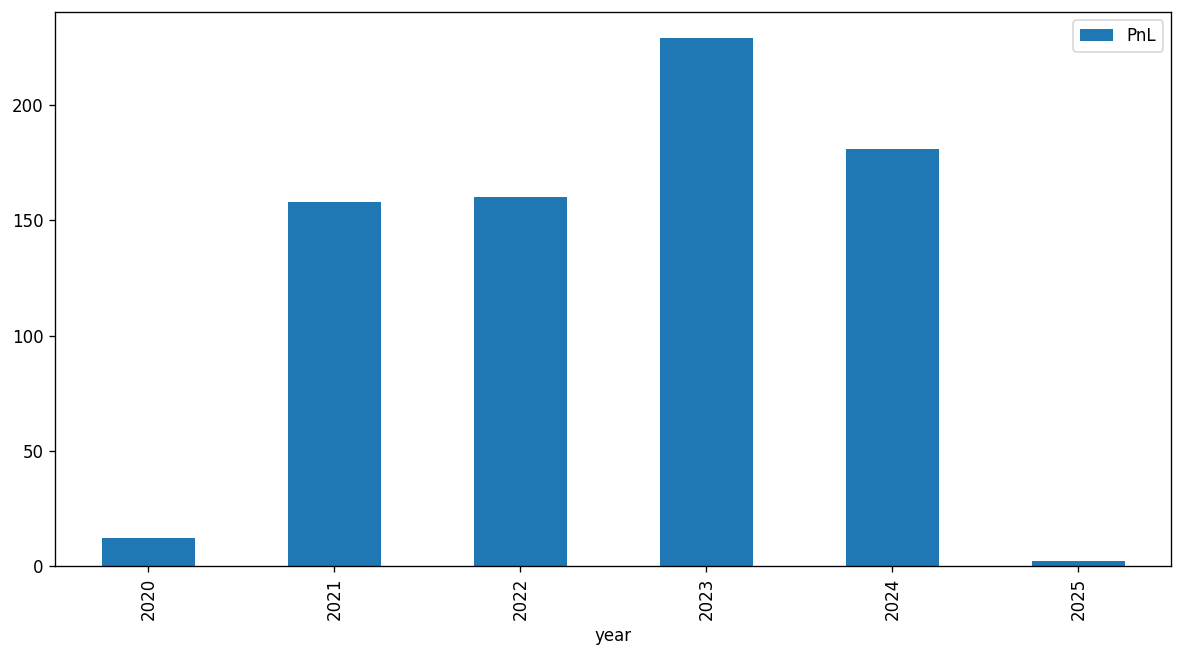

In [109]:
sum_pnl_trades_grouped_by_year = join_trades.groupby(['year'])[['PnL']].sum()
sum_pnl_trades_grouped_by_year.plot.bar()

## Optimize params

In [110]:
max_sl_params = [x / 10.0 for x in range(20, 50, 2)]
trailing_sl_params = [x / 10.0 for x in range(30, 100, 5)]
tp_step_params = [x for x in range(5, 35)]

In [111]:
trailing_sl_params

[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]

In [112]:
# optimize_stats, optimize_table = bt.optimize(
#                                       trailing_sl=trailing_sl_params,
#                                       tp_step=tp_step_params,
#                     maximize='Return [%]', 
#                     random_state=0,
#                     return_heatmap=True)

In [113]:
# optimize_stats

In [114]:
# optimize_table

In [115]:
# import seaborn as sns
# heatmap_df = optimize_table.unstack()
# plt.figure(figsize=(10, 8))
# sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
# plt.show()